# Imports

In [2]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import playbyplay,leaguegamefinder,leaguedashteamstats
from nba_api.stats.static import teams
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep
from tqdm.notebook import tqdm
pd.options.display.max_columns = None
from scipy import stats
import statsmodels.api as sm
from fitter import Fitter
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
plt.style.use('fivethirtyeight')

In [3]:
# Define a helper function to handle coalesce logic
def coalesce(*args):
    return next((arg for arg in args if pd.notnull(arg)), np.nan)

# Define a helper function to get the last non-NaN value
def last_non_nan(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else np.nan
# Define the getmode function
def getmode(x):
    uniqx, counts = np.unique(x, return_counts=True)
    return uniqx[np.argmax(counts)]

# Helper function to find first occurrence index
def first_occurrence(series):
    return (series.index[0] if series.any() else np.inf)

# Define a function to determine the first timeout used during a run
def first_timeout(x, timeout_col):
    timeouts = x[x[timeout_col]].index  # Get indices where timeout is True
    return timeouts[0] if not timeouts.empty else np.inf

# Define a function to determine period change within a run
def period_change(x):
    changes = x.index[x.shift(-1) != x]  # Get indices where period changes
    return changes[0] if not changes.empty else np.inf

# Preparation

In [3]:
SEASON_START = '2023-10-24'

In [4]:
teams_ids = [x['id'] for x in teams.get_teams()]

In [5]:
games = leaguegamefinder.LeagueGameFinder(team_id_nullable=teams_ids[0]).get_data_frames()[0]

In [6]:
games['SEASON_ID'].str[-4:]

0       2024
1       2024
2       2023
3       2023
4       2023
        ... 
3693    1983
3694    1983
3695    1983
3696    1983
3697    1983
Name: SEASON_ID, Length: 3698, dtype: object

In [7]:
all_games = []
for team in teams_ids:
    games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team).get_data_frames()[0]
    games = games[games['SEASON_ID'].astype(str).str.endswith('2023')]
    games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
    games = games[games['GAME_DATE']>=SEASON_START]
    all_games.extend(games['GAME_ID'].to_list())

In [8]:
all_games = list(set(all_games))

In [ ]:
# #df = pd.DataFrame()
# for game in tqdm_notebook(all_games):
#     if game in df['GAME_ID'].unique():
#         continue
#     else:
#         pbp = playbyplay.PlayByPlay(game_id=game).get_data_frames()[0]
#         df = pd.concat([df,pbp],ignore_index=True)
#         sleep(2)
# df.to_pickle('pbp_2023-24.pkl')

In [11]:
DATA_PATH = r'C:\Users\isaac\Desktop\Proyectos\nba_analysis\timeout_analysis\preprocessing\data'
# Define a helper function to handle coalesce logic
def coalesce(*args):
    return next((arg for arg in args if pd.notnull(arg)), np.nan)

# Define a helper function to get the last non-NaN value
def last_non_nan(series):
    return series.dropna().iloc[-1] if not series.dropna().empty else np.nan
# Define the getmode function
def getmode(x):
    uniqx, counts = np.unique(x, return_counts=True)
    return uniqx[np.argmax(counts)]

# Helper function to find first occurrence index
def first_occurrence(series):
    return (series.index[0] if series.any() else np.inf)

# Define a function to determine the first timeout used during a run
def first_timeout(x, timeout_col):
    timeouts = x[x[timeout_col]].index  # Get indices where timeout is True
    return timeouts[0] if not timeouts.empty else np.inf

# Define a function to determine period change within a run
def period_change(x):
    changes = x.index[x.shift(-1) != x]  # Get indices where period changes
    return changes[0] if not changes.empty else np.inf

SEASONS = ['2019','2020','2021','2022','2023']
teams_ids = [x['id'] for x in teams.get_teams()]
all_games_df = pd.DataFrame()
for team in teams_ids:
    games = leaguegamefinder.LeagueGameFinder(team_id_nullable=team).get_data_frames()[0]
    games['SEASON_YEAR'] = games['SEASON_ID'].str[-4:]
    games = games[games['SEASON_YEAR'].isin(SEASONS)]
    games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
    all_games_df = pd.concat([all_games_df,games],ignore_index=True)

# df = pd.DataFrame()
# for game in tqdm(all_games_df['GAME_ID'].unique()):
#     pbp = playbyplay.PlayByPlay(game_id=game).get_data_frames()[0]
#     df = pd.concat([df,pbp],ignore_index=True)
#     sleep(1)
# df.to_pickle(DATA_PATH+f'\pbp_{SEASONS[0]}-{SEASONS[-1]}.pkl')

print('Finished downloading play-by-play data')

# # Define keywords for turnovers
turnover_keywords = ['BLOCK', 'STEAL']

# Function to determine possession
def determine_possession(row):
    if row['VISITORDESCRIPTION'] and row['HOMEDESCRIPTION']:
        # If both descriptions are present, determine possession based on turnover keywords
        if any(keyword in row['VISITORDESCRIPTION'] for keyword in turnover_keywords):
            return row['HomeName']
        elif any(keyword in row['HOMEDESCRIPTION'] for keyword in turnover_keywords):
            return row['AwayName']
    # Default case where only one of the descriptions is present
    return row['AwayName'] if row['VISITORDESCRIPTION'] else row['HomeName']

teams_name_df = all_games_df[(all_games_df['MATCHUP'].str.contains('vs'))][['GAME_ID']]
teams_name_df['HomeName'] = all_games_df[(all_games_df['MATCHUP'].str.contains('vs'))]['MATCHUP'].str.split('vs.',expand=True)[0]
teams_name_df['AwayName'] = all_games_df[(all_games_df['MATCHUP'].str.contains('vs'))]['MATCHUP'].str.split('vs.',expand=True)[1]

df = pd.read_pickle(DATA_PATH+'\pbp_2019-2023.pkl')

<>:65: SyntaxWarning: invalid escape sequence '\p'
<>:65: SyntaxWarning: invalid escape sequence '\p'
C:\Users\isaac\AppData\Local\Temp\ipykernel_24656\3754080976.py:65: SyntaxWarning: invalid escape sequence '\p'
  df = pd.read_pickle(DATA_PATH+'\pbp_2019-2023.pkl')


Finished downloading play-by-play data


In [36]:
df = pd.read_pickle(DATA_PATH+'\pbp_2019-2023.pkl')

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\isaac\AppData\Local\Temp\ipykernel_24656\1685033570.py:1: SyntaxWarning: invalid escape sequence '\p'
  df = pd.read_pickle(DATA_PATH+'\pbp_2019-2023.pkl')


In [37]:
df = df.merge(teams_name_df,on='GAME_ID')
# Load the dataset
pbp_raw = df.iloc[:1000].copy()

# Turn play-by-play data into possessions
pbp = pbp_raw.copy()

# Convert game clock display to seconds remaining
pbp['qtr_seconds_remaining'] = pbp['PCTIMESTRING'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
# Data formatted so that events attributed to possessing team
# Remove non-action events
pbp = pbp[(pbp['NEUTRALDESCRIPTION'].isnull())]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("FOUL")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("FOUL")]
# Note upcoming timeouts before removing them
pbp['home_timeout_after'] = pbp['HOMEDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp['away_timeout_after'] = pbp['VISITORDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("Timeout") & ~pbp['HOMEDESCRIPTION'].fillna('').str.contains("Timeout")]
pbp['possession'] = pbp.apply(determine_possession, axis=1)

# # Group by GameID and possession
pbp['possession'] = pbp.groupby(['GAME_ID', 'possession'])['possession'].transform(getmode)

# # Assign key column to clusters of data
pbp['possession_id'] = pbp.groupby('GAME_ID')['possession'].apply(lambda x: (x != x.shift()).cumsum()+1).values
pbp[['VISITORSCORE','HOMESCORE']] = pbp['SCORE'].str.split('-',expand=True)
pbp['HOMESCORE'] = pbp['HOMESCORE'].astype(str).str.replace('None','NaN').astype(float)
pbp['VISITORSCORE'] = pbp['VISITORSCORE'].astype(str).str.replace('None','NaN').astype(float)
# pbp['HOMESCORE'].fillna(method='ffill',inplace=True)
# pbp['VISITORSCORE'].fillna(method='ffill',inplace=True)
pbp['coalesce_event'] = pbp.apply(lambda row: coalesce(row['VISITORDESCRIPTION'], row['HOMEDESCRIPTION']), axis=1)
# # Summary info for each possession

# Group by the relevant columns and summarize each possession
possession_summary = pbp.groupby(['GAME_ID', 'PERIOD', 'HomeName', 'AwayName', 'possession_id','possession']).agg(
    start=('qtr_seconds_remaining', 'min'),
    end=('qtr_seconds_remaining', 'max'),
    end_home_score=('HOMESCORE', 'max'),
    end_away_score=('VISITORSCORE', 'max'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.value_counts() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.value_counts() else False),
    last_event=('coalesce_event', 'last'),
).reset_index()
possession_summary['end_home_score'].fillna(0,inplace=True)
possession_summary['end_away_score'].fillna(0,inplace=True)

# Keep track of score
possession_summary['score'] = np.where(possession_summary['possession'] == possession_summary['HomeName'],
                                       possession_summary['end_home_score'] > possession_summary['end_home_score'].shift(),
                                       possession_summary['end_away_score'] > possession_summary['end_away_score'].shift())
possession_summary['last_score'] = np.where(possession_summary['score'], possession_summary['possession'], np.nan)

# Keep track of who scored last
possession_summary['last_score'] = possession_summary['last_score'].ffill()
possession_summary['last_score'] = possession_summary['last_score'].shift()

# Team identities required for matchup modeling
possession_summary['home_poss'] = possession_summary['possession'] == possession_summary['HomeName']
possession_summary['offense'] = np.where(possession_summary['home_poss'], possession_summary['HomeName'], possession_summary['AwayName'])
possession_summary['defense'] = np.where(possession_summary['home_poss'], possession_summary['AwayName'], possession_summary['HomeName'])
possession_summary['gp'] = possession_summary['GAME_ID'].astype(str) + possession_summary['PERIOD'].astype(str)
possession_summary = possession_summary[(possession_summary['end_home_score']>0)|(possession_summary['end_away_score']>0)]
#possession_summary.to_pickle(DATA_PATH+f'\possession_summary_{SEASONS[0]}-{SEASONS[-1]}.pkl')
print('Finished processing possessions')

Finished processing possessions


C:\Users\isaac\AppData\Local\Temp\ipykernel_24656\3306818572.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  possession_summary['end_home_score'].fillna(0,inplace=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_24656\3306818572.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a c

In [60]:
runs = pd.read_pickle(DATA_PATH+f'\possession_summary_{SEASONS[0]}-{SEASONS[-1]}.pkl')

runs['run_id'] = runs.groupby(['GAME_ID'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs['run_id_gp'] = runs.groupby(['gp'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\isaac\AppData\Local\Temp\ipykernel_24656\866453363.py:1: SyntaxWarning: invalid escape sequence '\p'
  runs = pd.read_pickle(DATA_PATH+f'\possession_summary_{SEASONS[0]}-{SEASONS[-1]}.pkl')


In [64]:
runs = pd.read_pickle(DATA_PATH+f'\possession_summary_{SEASONS[0]}-{SEASONS[-1]}.pkl')

runs['run_id'] = runs.groupby(['GAME_ID'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs['run_id_gp'] = runs.groupby(['gp'])['offense'].apply(lambda x: (x != x.shift()).cumsum()+1).values
runs.reset_index(inplace=True,drop=True)
runs['to_start'] = runs['start'] - 1

dict_all_runs = {
    'run_id_gp': [],
    'gp': [],
    'home_team': [],
    'away_team': [],
    'home_score': [],
    'away_score': [],
    'run_length': [],
    'to': [],
    'home_to': [],
    'away_to': [],
    'to_index': [],
    'changed_run': [],
    'run_team': [],
    'next_run_length': [],
    'next_run_home_score': [],
    'next_run_away_score': [],
    'next_run_team': [],
    'previous_run_length': [],
    'previous_run_home_score': [],
    'previous_run_away_score': [],
    'previous_run_team': [],
    'avg_opponent_run_length': [],
    'opponent_run_length_max': [],
    'opponent_run_length_min': [],
    'avg_own_run_length': [],
    'own_run_length_max': [],
    'own_run_length_min': [],
    'to_team': []
}

for ix, group in tqdm(runs.groupby(['gp', 'run_id_gp'])):
    run_id = group['run_id_gp'].iloc[0]
    gp = group['gp'].iloc[0]
    home_team = group['HomeName'].iloc[0]
    away_team = group['AwayName'].iloc[0]
    home_score = group['end_home_score'].iloc[-1]
    away_score = group['end_away_score'].iloc[-1]
    run_length = group.shape[0]
    run_team = group['possession'].transform(getmode).iloc[0]
    previous_run_team = group['defense'].transform(getmode).iloc[0]
    gp_int = int(gp)
    # Calculate timeouts and run changes
    if True in group['home_timeout_after'].values:
        to = 1
        home_to = 1
        away_to = 0
        to_list = group['home_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'home'
    elif True in group['away_timeout_after'].values:
        to = 1
        home_to = 0
        away_to = 1
        to_list = group['away_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'away'
    else:
        to, home_to, away_to, true_index, changed_run = 0, 0, 0, 0, 0
        timeout = np.nan

    # Find next and previous runs within the same game-period (gp)
    next_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id + 1)]
    prev_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id - 1)]

    if not next_run.empty:
        next_run_length = next_run.shape[0]
        next_run_home_score = next_run['end_home_score'].iloc[-1]
        next_run_away_score = next_run['end_away_score'].iloc[-1]
        next_run_team = next_run['offense'].iloc[0]
    else:
        try:
            next_gp = str(gp_int + 1).zfill(11)
            next_run = runs[(runs['gp'] == next_gp)]
            next_run = next_run[next_run['run_id_gp'] == next_run['run_id_gp'].min()]
            next_run_length = next_run.shape[0]
            next_run_home_score = next_run['end_home_score'].iloc[-1]
            next_run_away_score = next_run['end_away_score'].iloc[-1]
            next_run_team = next_run['offense'].iloc[0]
        except:
            next_run_length, next_run_home_score, next_run_away_score, next_run_team = 0, 0, 0, np.nan

    if not prev_run.empty:
        previous_run_length = prev_run.shape[0]
        previous_run_home_score = prev_run['end_home_score'].iloc[-1]
        previous_run_away_score = prev_run['end_away_score'].iloc[-1]
        previous_run_team = prev_run['offense'].iloc[0]
    else:
        try:
            prev_gp = str(gp_int - 1).zfill(11)
            previous_run = runs[(runs['gp'] == prev_gp)]
            previous_run = previous_run[previous_run['run_id_gp'] == previous_run['run_id_gp'].max()]
            previous_run_length = previous_run.shape[0]
            previous_run_home_score = previous_run['end_home_score'].iloc[-1]
            previous_run_away_score = previous_run['end_away_score'].iloc[-1]
            previous_run_team = previous_run['offense'].iloc[0]
        except:
            previous_run_length, previous_run_home_score, previous_run_away_score, previous_run_team = 0, 0, 0, np.nan
    previous_5_runs_own = [run_id-i for i in range(2, 14,2)]
    previous_5_runs_opponent = [run_id-i for i in range(1, 12,2)]
    # Get the previous 5 runs by the same team and opponent
    prev_own_runs = runs[(runs['gp'] == gp) & (runs['offense'] == run_team) & (runs['run_id_gp'].isin(previous_5_runs_own))]
    prev_opponent_runs = runs[(runs['gp'] == gp) & (runs['offense'] != run_team) & (runs['run_id_gp'].isin(previous_5_runs_opponent))]

    if not prev_own_runs.empty:
        avg_own_run_length = (prev_own_runs.groupby('run_id_gp').size()).mean()
        own_run_length_max = (prev_own_runs.groupby('run_id_gp').size()).max()
        own_run_length_min = (prev_own_runs.groupby('run_id_gp').size()).min()
    else:
        avg_own_run_length, own_run_length_max, own_run_length_min = None, None, None

    if not prev_opponent_runs.empty:
        avg_opponent_run_length = (prev_opponent_runs.groupby('run_id_gp').size()).mean()
        opponent_run_length_max = (prev_opponent_runs.groupby('run_id_gp').size()).max()
        opponent_run_length_min = (prev_opponent_runs.groupby('run_id_gp').size()).min()
    else:
        avg_opponent_run_length, opponent_run_length_max, opponent_run_length_min = None, None, None
    if timeout == 'home':
        to_team = home_team
    elif timeout == 'away':
        to_team = away_team
    else:
        to_team = np.nan
    # Append values to the dictionary during your analysis
    dict_all_runs['run_id_gp'].append(run_id)
    dict_all_runs['gp'].append(gp)
    dict_all_runs['home_team'].append(home_team)
    dict_all_runs['away_team'].append(away_team)
    dict_all_runs['home_score'].append(home_score)
    dict_all_runs['away_score'].append(away_score)
    dict_all_runs['run_team'].append(run_team)
    dict_all_runs['run_length'].append(run_length)
    dict_all_runs['to'].append(to)
    dict_all_runs['home_to'].append(home_to)
    dict_all_runs['away_to'].append(away_to)
    dict_all_runs['to_index'].append(true_index)
    dict_all_runs['changed_run'].append(changed_run)
    dict_all_runs['next_run_length'].append(next_run_length)
    dict_all_runs['next_run_home_score'].append(next_run_home_score)
    dict_all_runs['next_run_away_score'].append(next_run_away_score)
    dict_all_runs['next_run_team'].append(next_run_team)
    dict_all_runs['previous_run_length'].append(previous_run_length)
    dict_all_runs['previous_run_home_score'].append(previous_run_home_score)
    dict_all_runs['previous_run_away_score'].append(previous_run_away_score)
    dict_all_runs['previous_run_team'].append(previous_run_team)
    dict_all_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_all_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_all_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_all_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_all_runs['own_run_length_max'].append(own_run_length_max)
    dict_all_runs['own_run_length_min'].append(own_run_length_min)
    dict_all_runs['to_team'].append(to_team)

all_runs_to = pd.DataFrame(dict_all_runs)
for ix, row in all_runs_to.iterrows():
    if row['to']==1:
        if row['home_to']==1:
            all_runs_to.loc[ix,'to_team'] = row['home_team']
        else:
            all_runs_to.loc[ix,'to_team'] = row['away_team']
    else:
        all_runs_to.loc[ix,'to_team'] = np.nan

for ix, row in all_runs_to.iterrows():
    if row['to']==1:
        if row['run_team'] != row['to_team']:
            all_runs_to.loc[ix,'to_non_run'] = 1
        else:
            all_runs_to.loc[ix,'to_non_run'] = 0
    else:
        all_runs_to.loc[ix,'to_non_run'] = np.nan

to_sec_start_df = runs[(runs['home_timeout_after']==True)|(runs['away_timeout_after']==True)].groupby(['gp','run_id_gp'],as_index=False)['to_start'].last()
dict_times = {'previous_time_list' : [],
'min_time_list' : [],
'time_spent_list' : [],
'to_time_list ': []}
for ix,group in tqdm(runs.groupby(['gp','run_id_gp'])):
    min_time = group['start'].min()
    gp = group['gp'].iloc[0]
    run_id = group['run_id_gp'].iloc[0]
    if run_id == 2:
        previous_run_min_time = 720
        time_spent = previous_run_min_time - min_time
    else:
        previous_run_min_time = runs[(runs['gp']==gp)&(runs['run_id_gp']==run_id-1)]['start'].min()
        time_spent = previous_run_min_time - min_time
    df_sec_to = to_sec_start_df.loc[(to_sec_start_df['gp']==gp)&(to_sec_start_df['run_id_gp']==run_id)]
    if df_sec_to.empty:
        to_time = np.nan
    else:
        to_time = df_sec_to['to_start'].iloc[0]
    dict_times['previous_time_list'].append(previous_run_min_time)
    dict_times['min_time_list'].append(min_time)
    dict_times['time_spent_list'].append(time_spent)
    dict_times['to_time_list '].append(to_time)
times_df = pd.DataFrame(dict_times)
times_df.columns = ['previous_run_time','last_run_time','time_spent_run','to_time']

all_runs_to = pd.concat([all_runs_to,times_df],axis=1)

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\isaac\AppData\Local\Temp\ipykernel_24656\3168619463.py:1: SyntaxWarning: invalid escape sequence '\p'
  runs = pd.read_pickle(DATA_PATH+f'\possession_summary_{SEASONS[0]}-{SEASONS[-1]}.pkl')


  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [67]:
all_runs_to

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time
0,2,00219008381,MIA,CLE,6.0,0.0,2,0,0,0,0,0,MIA,1,6.0,2.0,CLE,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720,667,53,NaN
1,3,00219008381,MIA,CLE,6.0,2.0,1,0,0,0,0,0,CLE,1,9.0,2.0,MIA,2,6.0,0.0,MIA,2.000000,2.0,2.0,NaN,NaN,NaN,NaN,NaN,667,619,48,NaN
2,4,00219008381,MIA,CLE,9.0,2.0,1,0,0,0,0,0,MIA,1,11.0,4.0,CLE,1,6.0,2.0,CLE,1.000000,1.0,1.0,2.000000,2.0,2.0,NaN,NaN,619,607,12,NaN
3,5,00219008381,MIA,CLE,11.0,4.0,1,0,0,0,0,0,CLE,1,13.0,4.0,MIA,1,9.0,2.0,MIA,1.500000,2.0,1.0,1.000000,1.0,1.0,NaN,NaN,607,570,37,NaN
4,6,00219008381,MIA,CLE,13.0,4.0,1,1,0,1,0,1,MIA,2,13.0,6.0,CLE,1,11.0,4.0,CLE,1.000000,1.0,1.0,1.500000,2.0,1.0,CLE,1.0,570,546,24,545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,18,00222005601,LAC,MIA,25.0,29.0,2,0,0,0,0,0,LAC,1,25.0,31.0,MIA,2,21.0,29.0,MIA,1.833333,4.0,1.0,1.166667,2.0,1.0,NaN,NaN,141,99,42,NaN
136,19,00222005601,LAC,MIA,25.0,31.0,1,0,0,0,0,0,MIA,1,28.0,31.0,LAC,2,25.0,29.0,LAC,1.333333,2.0,1.0,1.833333,4.0,1.0,NaN,NaN,99,83,16,NaN
137,20,00222005601,LAC,MIA,28.0,31.0,1,0,0,0,0,0,LAC,1,28.0,34.0,MIA,1,25.0,31.0,MIA,1.833333,4.0,1.0,1.333333,2.0,1.0,NaN,NaN,83,67,16,NaN
138,21,00222005601,LAC,MIA,28.0,34.0,1,0,0,0,0,0,MIA,1,30.0,34.0,LAC,1,28.0,31.0,LAC,1.166667,2.0,1.0,1.833333,4.0,1.0,NaN,NaN,67,23,44,NaN


In [9]:
df = pd.read_pickle('pbp_2023-24.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'pbp_2023-24.pkl'

In [ ]:
# Define keywords for turnovers
turnover_keywords = ['BLOCK', 'STEAL']

# Function to determine possession
def determine_possession(row):
    if row['VISITORDESCRIPTION'] and row['HOMEDESCRIPTION']:
        # If both descriptions are present, determine possession based on turnover keywords
        if any(keyword in row['VISITORDESCRIPTION'] for keyword in turnover_keywords):
            return row['HomeName']
        elif any(keyword in row['HOMEDESCRIPTION'] for keyword in turnover_keywords):
            return row['AwayName']
    # Default case where only one of the descriptions is present
    return row['AwayName'] if row['VISITORDESCRIPTION'] else row['HomeName']

In [681]:
first_timeout_seconds = 6 * 60 + 59
second_timeout_seconds = 2 * 60 + 59

In [198]:
# Load the dataset
pbp_raw = df.copy()

# Turn play-by-play data into possessions
pbp = pbp_raw.copy()
# pbp['date'] = pd.to_datetime(pbp['Date'], format="%m/%d/%Y")
# pbp['month'] = pbp['date'].dt.month
# pbp['day'] = pbp['date'].dt.day
# pbp['year'] = pbp['date'].dt.year

# Convert game clock display to seconds remaining
pbp['qtr_seconds_remaining'] = pbp['PCTIMESTRING'].apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))
pbp['AwayName'] = ''
pbp['HomeName'] = ''
for game in pbp['GAME_ID'].unique():
    pbp.loc[pbp['GAME_ID']==game,'AwayName'] = pbp[(pbp['EVENTMSGTYPE']==9)&(pbp['GAME_ID']==game)]['VISITORDESCRIPTION'].str.split(' ',expand=True)[0].value_counts().index[0].capitalize()
    pbp.loc[pbp['GAME_ID']==game,'HomeName'] = pbp[(pbp['EVENTMSGTYPE']==9)&(pbp['GAME_ID']==game)]['HOMEDESCRIPTION'].str.split(' ',expand=True)[0].value_counts().index[0].capitalize()
# Data formatted so that events attributed to possessing team
# Remove non-action events
pbp = pbp[(pbp['NEUTRALDESCRIPTION'].isnull())]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("FOUL")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("SUB")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains('REPLAY')]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("KICKED")]
pbp = pbp[~pbp['HOMEDESCRIPTION'].fillna('').str.contains("FOUL")]
# Note upcoming timeouts before removing them
pbp['home_timeout_after'] = pbp['HOMEDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp['away_timeout_after'] = pbp['VISITORDESCRIPTION'].shift(-1).fillna('').str.contains("Timeout")
pbp = pbp[~pbp['VISITORDESCRIPTION'].fillna('').str.contains("Timeout") & ~pbp['HOMEDESCRIPTION'].fillna('').str.contains("Timeout")]
pbp['possession'] = pbp.apply(determine_possession, axis=1)

# # Group by GameID and possession
pbp['possession'] = pbp.groupby(['GAME_ID', 'possession'])['possession'].transform(getmode)

# # Assign key column to clusters of data
pbp['possession_id'] = pbp.groupby('GAME_ID')['possession'].apply(lambda x: (x != x.shift()).cumsum())
pbp[['VISITORSCORE','HOMESCORE']] = pbp['SCORE'].str.split('-',expand=True)
pbp['HOMESCORE'] = pbp['HOMESCORE'].astype(str).str.replace('None','NaN').astype(float)
pbp['VISITORSCORE'] = pbp['VISITORSCORE'].astype(str).str.replace('None','NaN').astype(float)
# pbp['HOMESCORE'].fillna(method='ffill',inplace=True)
# pbp['VISITORSCORE'].fillna(method='ffill',inplace=True)
pbp['coalesce_event'] = pbp.apply(lambda row: coalesce(row['VISITORDESCRIPTION'], row['HOMEDESCRIPTION']), axis=1)
# # Summary info for each possession

# Group by the relevant columns and summarize each possession
possession_summary = pbp.groupby(['GAME_ID', 'PERIOD', 'HomeName', 'AwayName', 'possession_id','possession']).agg(
    start=('qtr_seconds_remaining', 'min'),
    end=('qtr_seconds_remaining', 'max'),
    end_home_score=('HOMESCORE', 'max'),
    end_away_score=('VISITORSCORE', 'max'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.value_counts() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.value_counts() else False),
    last_event=('coalesce_event', 'last'),
).reset_index()
possession_summary['end_home_score'].fillna(0,inplace=True)
possession_summary['end_away_score'].fillna(0,inplace=True)

# Keep track of score
possession_summary['score'] = np.where(possession_summary['possession'] == possession_summary['HomeName'],
                                       possession_summary['end_home_score'] > possession_summary['end_home_score'].shift(),
                                       possession_summary['end_away_score'] > possession_summary['end_away_score'].shift())
possession_summary['last_score'] = np.where(possession_summary['score'], possession_summary['possession'], np.nan)

# Keep track of who scored last
possession_summary['last_score'] = possession_summary['last_score'].ffill()
possession_summary['last_score'] = possession_summary['last_score'].shift()

# Team identities required for matchup modeling
possession_summary['home_poss'] = possession_summary['possession'] == possession_summary['HomeName']
possession_summary['offense'] = np.where(possession_summary['home_poss'], possession_summary['HomeName'], possession_summary['AwayName'])
possession_summary['defense'] = np.where(possession_summary['home_poss'], possession_summary['AwayName'], possession_summary['HomeName'])
possession_summary['gp'] = possession_summary['GAME_ID'].astype(str) + possession_summary['PERIOD'].astype(str)

C:\Users\isaac\AppData\Local\Temp\ipykernel_14960\480830038.py:44: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pbp['possession_id'] = pbp.groupby('GAME_ID')['possession'].apply(lambda x: (x != x.shift()).cumsum())


In [199]:
possession_summary.to_pickle('possession_summary_2023-24.pkl')

In [269]:
possession_summary = pd.read_pickle('possession_summary_2023-24.pkl')

In [270]:
possession_summary = possession_summary[(possession_summary['end_home_score']>0)|(possession_summary['end_away_score']>0)]

In [271]:
runs = possession_summary.copy()

In [272]:
runs['run_id'] = (runs.groupby(['GAME_ID','score'])['offense'].apply(lambda x: (x != x.shift()).cumsum()) + 1).values
runs['run_id_gp'] = ((runs.groupby(['gp','score'])['offense'].apply(lambda x: (x != x.shift()).cumsum()))+1).values

In [219]:

# Aggregate possession info over runs (game)
runs_agg = runs.groupby(['GAME_ID',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    timeout=('home_poss', lambda x: first_timeout(runs.loc[x.index], 'away_timeout_after') if x.iloc[0] else first_timeout(runs.loc[x.index], 'home_timeout_after')),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last')
).reset_index()

# Aggregate possession info over runs (game-period)
runs_agg_gp = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    timeout=('home_poss', lambda x: first_timeout(runs.loc[x.index], 'away_timeout_after') if x.iloc[0] else first_timeout(runs.loc[x.index], 'home_timeout_after')),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last')
).reset_index()


In [49]:
runs_agg_gp.to_pickle('runs_agg_gp_2023-24.pkl')
runs_agg.to_pickle('runs_agg_2023-24.pkl')

# EDA

In [17]:
runs_agg_gp = pd.read_pickle('runs_agg_gp_2023-24.pkl')
runs_agg = pd.read_pickle('runs_agg_2023-24.pkl')

<Axes: xlabel='timeout'>

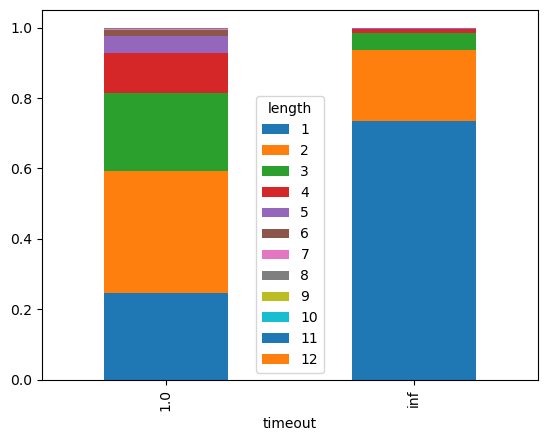

In [9]:
runs_agg_gp.groupby('timeout')['length'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True)

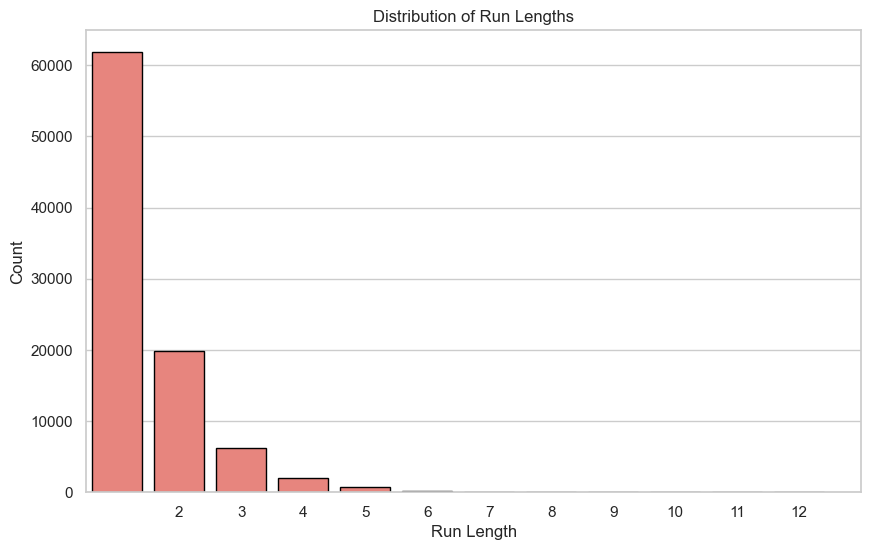

In [52]:
# Set the figure size for better clarity
plt.figure(figsize=(10, 6))

# Plot the data using seaborn's countplot
sns.countplot(data=runs_agg_gp, x='length', color='#F8766D', edgecolor='black')

# Set the breaks for x-axis
max_length = runs_agg_gp['length'].max()
plt.xticks(ticks=range(1, max_length + 1))

# Apply a theme similar to theme_bw in ggplot2
sns.set_theme(style="whitegrid")

# Adding labels
plt.xlabel("Run Length")
plt.ylabel("Count")

# Show the plot
plt.title("Distribution of Run Lengths")
plt.show()

In [273]:
runs.reset_index(inplace=True,drop=True)
runs['to_start'] = runs['start'] - 1

In [145]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

In [203]:
#test = test[((test['away_timeout_after']==True)&(test['home_timeout_after']==False))|((test['away_timeout_after']==False)&(test['home_timeout_after']==True))]

In [206]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

In [274]:
dict_all_runs = {
    'run_id_gp': [],
    'gp': [],
    'home_team': [],
    'away_team': [],
    'home_score': [],
    'away_score': [],
    'run_length': [],
    'to': [],
    'home_to': [],
    'away_to': [],
    'to_index': [],
    'changed_run': [],
    'run_team': [],
    'next_run_length': [],
    'next_run_home_score': [],
    'next_run_away_score': [],
    'next_run_team': [],
    'previous_run_length': [],
    'previous_run_home_score': [],
    'previous_run_away_score': [],
    'previous_run_team': [],
    'avg_opponent_run_length': [],
    'opponent_run_length_max': [],
    'opponent_run_length_min': [],
    'avg_own_run_length': [],
    'own_run_length_max': [],
    'own_run_length_min': [],
    'to_team': []
}

for ix, group in runs.head(29).groupby(['gp', 'run_id_gp']):
    run_id = group['run_id_gp'].iloc[0]
    gp = group['gp'].iloc[0]
    home_team = group['HomeName'].iloc[0]
    away_team = group['AwayName'].iloc[0]
    home_score = group['end_home_score'].iloc[-1]
    away_score = group['end_away_score'].iloc[-1]
    run_length = group.shape[0]
    run_team = group['offense'].iloc[0]
    previous_run_team = group['defense'].iloc[0]
    gp_int = int(gp)
    # Calculate timeouts and run changes
    if True in group['home_timeout_after'].values:
        to = 1
        home_to = 1
        away_to = 0
        to_list = group['home_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'home'
    elif True in group['away_timeout_after'].values:
        to = 1
        home_to = 0
        away_to = 1
        to_list = group['away_timeout_after'].to_list()
        true_index = to_list.index(True)
        if true_index + 1 == run_length:
            changed_run = 1
        timeout = 'away'
    else:
        to, home_to, away_to, true_index, changed_run = 0, 0, 0, 0, 0
        timeout = np.nan

    # Find next and previous runs within the same game-period (gp)
    next_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id + 1)]
    prev_run = runs[(runs['gp'] == gp) & (runs['run_id_gp'] == run_id - 1)]

    if not next_run.empty:
        next_run_length = next_run.shape[0]
        next_run_home_score = next_run['end_home_score'].iloc[-1]
        next_run_away_score = next_run['end_away_score'].iloc[-1]
        next_run_team = next_run['offense'].iloc[0]
    else:
        try:
            next_gp = str(gp_int + 1).zfill(11)
            next_run = runs[(runs['gp'] == next_gp)]
            next_run = next_run[next_run['run_id_gp'] == next_run['run_id_gp'].min()]
            next_run_length = next_run.shape[0]
            next_run_home_score = next_run['end_home_score'].iloc[-1]
            next_run_away_score = next_run['end_away_score'].iloc[-1]
            next_run_team = next_run['offense'].iloc[0]
        except:
            next_run_length, next_run_home_score, next_run_away_score, next_run_team = 0, 0, 0, np.nan

    if not prev_run.empty:
        previous_run_length = prev_run.shape[0]
        previous_run_home_score = prev_run['end_home_score'].iloc[-1]
        previous_run_away_score = prev_run['end_away_score'].iloc[-1]
        previous_run_team = prev_run['offense'].iloc[0]
    else:
        try:
            prev_gp = str(gp_int - 1).zfill(11)
            previous_run = runs[(runs['gp'] == prev_gp)]
            previous_run = previous_run[previous_run['run_id_gp'] == previous_run['run_id_gp'].max()]
            previous_run_length = previous_run.shape[0]
            previous_run_home_score = previous_run['end_home_score'].iloc[-1]
            previous_run_away_score = previous_run['end_away_score'].iloc[-1]
            previous_run_team = previous_run['offense'].iloc[0]
        except:
            previous_run_length, previous_run_home_score, previous_run_away_score, previous_run_team = 0, 0, 0, np.nan
    previous_5_runs_own = [run_id-i for i in range(2, 14,2)]
    previous_5_runs_opponent = [run_id-i for i in range(1, 12,2)]
    # Get the previous 5 runs by the same team and opponent
    prev_own_runs = runs[(runs['gp'] == gp) & (runs['offense'] == run_team) & (runs['run_id_gp'].isin(previous_5_runs_own))]
    prev_opponent_runs = runs[(runs['gp'] == gp) & (runs['offense'] != run_team) & (runs['run_id_gp'].isin(previous_5_runs_opponent))]

    if not prev_own_runs.empty:
        avg_own_run_length = (prev_own_runs.groupby('run_id_gp').size()).mean()
        own_run_length_max = (prev_own_runs.groupby('run_id_gp').size()).max()
        own_run_length_min = (prev_own_runs.groupby('run_id_gp').size()).min()
    else:
        avg_own_run_length, own_run_length_max, own_run_length_min = None, None, None

    if not prev_opponent_runs.empty:
        avg_opponent_run_length = (prev_opponent_runs.groupby('run_id_gp').size()).mean()
        opponent_run_length_max = (prev_opponent_runs.groupby('run_id_gp').size()).max()
        opponent_run_length_min = (prev_opponent_runs.groupby('run_id_gp').size()).min()
    else:
        avg_opponent_run_length, opponent_run_length_max, opponent_run_length_min = None, None, None
    if timeout == 'home':
        to_team = home_team
    elif timeout == 'away':
        to_team = away_team
    else:
        to_team = np.nan
    # Append values to the dictionary during your analysis
    dict_all_runs['run_id_gp'].append(run_id)
    dict_all_runs['gp'].append(gp)
    dict_all_runs['home_team'].append(home_team)
    dict_all_runs['away_team'].append(away_team)
    dict_all_runs['home_score'].append(home_score)
    dict_all_runs['away_score'].append(away_score)
    dict_all_runs['run_team'].append(run_team)
    dict_all_runs['run_length'].append(run_length)
    dict_all_runs['to'].append(to)
    dict_all_runs['home_to'].append(home_to)
    dict_all_runs['away_to'].append(away_to)
    dict_all_runs['to_index'].append(true_index)
    dict_all_runs['changed_run'].append(changed_run)
    dict_all_runs['next_run_length'].append(next_run_length)
    dict_all_runs['next_run_home_score'].append(next_run_home_score)
    dict_all_runs['next_run_away_score'].append(next_run_away_score)
    dict_all_runs['next_run_team'].append(next_run_team)
    dict_all_runs['previous_run_length'].append(previous_run_length)
    dict_all_runs['previous_run_home_score'].append(previous_run_home_score)
    dict_all_runs['previous_run_away_score'].append(previous_run_away_score)
    dict_all_runs['previous_run_team'].append(previous_run_team)
    dict_all_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_all_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_all_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_all_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_all_runs['own_run_length_max'].append(own_run_length_max)
    dict_all_runs['own_run_length_min'].append(own_run_length_min)
    dict_all_runs['to_team'].append(to_team)

In [275]:
df_as = pd.DataFrame(dict_all_runs)

In [276]:
df_as

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_length,to,home_to,away_to,to_index,changed_run,run_team,next_run_length,next_run_home_score,next_run_away_score,next_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,previous_run_team,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,to_team
0,2,00223000011,Pacers,Cavaliers,5.0,0.0,2,0,0,0,0,0,Pacers,2,5.0,5.0,Cavaliers,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,00223000011,Pacers,Cavaliers,5.0,5.0,2,0,0,0,0,0,Cavaliers,3,12.0,5.0,Pacers,2,5.0,0.0,Pacers,2.000000,2.0,2.0,NaN,NaN,NaN,NaN
2,4,00223000011,Pacers,Cavaliers,12.0,5.0,3,0,0,0,0,0,Pacers,1,12.0,7.0,Cavaliers,2,5.0,5.0,Cavaliers,2.000000,2.0,2.0,2.000000,2.0,2.0,NaN
3,5,00223000011,Pacers,Cavaliers,12.0,7.0,1,0,0,0,0,0,Cavaliers,1,15.0,7.0,Pacers,3,12.0,5.0,Pacers,2.500000,3.0,2.0,2.000000,2.0,2.0,NaN
4,6,00223000011,Pacers,Cavaliers,15.0,7.0,1,0,0,0,0,0,Pacers,1,15.0,9.0,Cavaliers,1,12.0,7.0,Cavaliers,1.500000,2.0,1.0,2.500000,3.0,2.0,NaN
5,7,00223000011,Pacers,Cavaliers,15.0,9.0,1,0,0,0,0,0,Cavaliers,1,17.0,9.0,Pacers,1,15.0,7.0,Pacers,2.000000,3.0,1.0,1.500000,2.0,1.0,NaN
6,8,00223000011,Pacers,Cavaliers,17.0,9.0,1,1,0,1,0,1,Pacers,1,17.0,11.0,Cavaliers,1,15.0,9.0,Cavaliers,1.333333,2.0,1.0,2.000000,3.0,1.0,Cavaliers
7,9,00223000011,Pacers,Cavaliers,17.0,11.0,1,0,0,0,0,0,Cavaliers,1,20.0,11.0,Pacers,1,17.0,9.0,Pacers,1.750000,3.0,1.0,1.333333,2.0,1.0,NaN
8,10,00223000011,Pacers,Cavaliers,20.0,11.0,1,0,0,0,0,0,Pacers,1,20.0,13.0,Cavaliers,1,17.0,11.0,Cavaliers,1.250000,2.0,1.0,1.750000,3.0,1.0,NaN
9,11,00223000011,Pacers,Cavaliers,20.0,13.0,1,0,0,0,0,0,Cavaliers,1,22.0,13.0,Pacers,1,20.0,11.0,Pacers,1.600000,3.0,1.0,1.250000,2.0,1.0,NaN


In [259]:
df_as['net_diff'] = (df_as['home_score'] - df_as['previous_run_home_score']) - (df_as['away_score'] - df_as['previous_run_away_score'])

In [197]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

In [195]:
#test = test[((test['away_timeout_after']==True)&(test['home_timeout_after']==False))|((test['away_timeout_after']==False)&(test['home_timeout_after']==True))]

In [198]:
test

,gp,run_id_gp,offense,defense,home_poss,length,home_timeout_after,away_timeout_after,start_period,period_change,home_score,away_score,home_team,away_team
0,00223000011,2,Pacers,Cavaliers,True,2,False,False,1,1,5.0,0.0,Pacers,Cavaliers
1,00223000011,3,Cavaliers,Pacers,False,2,False,False,1,3,5.0,5.0,Pacers,Cavaliers
2,00223000011,4,Pacers,Cavaliers,True,3,False,False,1,6,12.0,5.0,Pacers,Cavaliers
3,00223000011,5,Cavaliers,Pacers,False,1,False,False,1,7,12.0,7.0,Pacers,Cavaliers
4,00223000011,6,Pacers,Cavaliers,True,1,False,False,1,8,15.0,7.0,Pacers,Cavaliers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90933,00623000014,17,Pacers,Lakers,False,1,False,False,4,133756,118.0,106.0,Lakers,Pacers
90934,00623000014,18,Lakers,Pacers,True,1,False,False,4,133757,121.0,106.0,Lakers,Pacers
90935,00623000014,19,Pacers,Lakers,False,1,False,False,4,133758,121.0,108.0,Lakers,Pacers
90936,00623000014,20,Lakers,Pacers,True,1,False,False,4,133759,123.0,108.0,Lakers,Pacers


In [204]:
dict_runs ={'run_id_gp':[],
            'home_team':[],'away_team':[],
            'gp':[],'to_team':[],'timeout':[],
            'net_diff':[],'opponent_run_length':[],
            'avg_opponent_run_length':[],'opponent_run_length_max':[],
            'opponent_run_length_min':[],'own_run_length':[],
            'avg_own_run_length':[],'own_run_length_max':[],
            'own_run_length_min':[],'previous_opp_run':[],'previous_opp_run_length':[]}
for ix in tqdm(test[(test['run_id_gp']<=13) & (test['gp']=='00223000011')].index):
    run_id = test.loc[ix,'run_id_gp']
    home_to = test.loc[ix,'home_timeout_after']
    away_to = test.loc[ix,'away_timeout_after']
    gp = test.loc[ix,'gp']
    if home_to == True:
        to_team = test.loc[ix,'home_team']
        timeout = 'home'
    else:
        to_team = test.loc[ix,'away_team']
        timeout = 'away'
    
    run_df = test.loc[(test['run_id_gp']<=run_id)&(test['gp']==gp)&((test['away_timeout_after']==False)|(test['home_timeout_after']==False))]
    other_team_runs = run_df[(run_df['offense']!=to_team)].iloc[-5:]
    to_team_runs = run_df[(run_df['offense']==to_team)].iloc[-5:]
    if timeout == 'home':
        try:
            net_diff = (run_df['home_score'].iloc[-1] - run_df['home_score'].iloc[0]) - (run_df['away_score'].iloc[-1] - run_df['away_score'].iloc[0])
        except:
            net_diff = run_df['home_score'] - run_df['away_score']
    else:
        try:
            net_diff = (run_df['away_score'].iloc[-1] - run_df['away_score'].iloc[0]) - (run_df['home_score'].iloc[-1] - run_df['home_score'].iloc[0])
        except:
            net_diff = run_df['home_score'] - run_df['away_score']
    if other_team_runs.empty:
        opponent_run_length = 0
        avg_opponent_run_length = 0
        opponent_run_length_max = 0
        opponent_run_length_min = 0
    else:
        opponent_run_length = other_team_runs.iloc[-1]['length']
        avg_opponent_run_length = other_team_runs['length'].mean()
        opponent_run_length_max = other_team_runs['length'].max()
        opponent_run_length_min = other_team_runs['length'].min()
    if to_team_runs.empty:
        own_run_length = 0
        avg_own_run_length = 0
        own_run_length_max = 0
        own_run_length_min = 0
    else:
        own_run_length = to_team_runs.iloc[-1]['length']
        avg_own_run_length = to_team_runs['length'].mean()
        own_run_length_max = to_team_runs['length'].max()
        own_run_length_min = to_team_runs['length'].min()
    if to_team == run_df.iloc[-1]['offense']:
        previous_opp_run = 0
        previous_opp_run_length = 0
    else:
        previous_opp_run = 1
        previous_opp_run_length = run_df.iloc[-1]['length']
    dict_runs['run_id_gp'].append(run_id)
    dict_runs['home_team'].append(test.loc[ix,'home_team'])
    dict_runs['away_team'].append(test.loc[ix,'away_team'])
    dict_runs['gp'].append(gp)
    dict_runs['to_team'].append(to_team)
    dict_runs['timeout'].append(timeout)
    dict_runs['net_diff'].append(net_diff)
    dict_runs['opponent_run_length'].append(opponent_run_length)
    dict_runs['avg_opponent_run_length'].append(avg_opponent_run_length)
    dict_runs['opponent_run_length_max'].append(opponent_run_length_max)
    dict_runs['opponent_run_length_min'].append(opponent_run_length_min)
    dict_runs['own_run_length'].append(own_run_length)
    dict_runs['avg_own_run_length'].append(avg_own_run_length)
    dict_runs['own_run_length_max'].append(own_run_length_max)
    dict_runs['own_run_length_min'].append(own_run_length_min)
    dict_runs['previous_opp_run'].append(previous_opp_run)
    dict_runs['previous_opp_run_length'].append(previous_opp_run_length)

  0%|          | 0/2 [00:00<?, ?it/s]

In [205]:
pd.DataFrame(dict_runs)

,run_id_gp,home_team,away_team,gp,to_team,timeout,net_diff,opponent_run_length,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,own_run_length,avg_own_run_length,own_run_length_max,own_run_length_min,previous_opp_run,previous_opp_run_length
0,8,Pacers,Cavaliers,00223000011,Cavaliers,away,0.0,1,1.0,1,1,0,0.0,0,0,1,1
1,13,Pacers,Cavaliers,00223000011,Pacers,home,-3.0,2,2.0,2,2,1,1.0,1,1,1,2


In [40]:
timeout_df = pd.DataFrame(dict_runs)

In [61]:
dict_next_run = {'run_id_gp':[],'gp':[],'next_run_id':[],'next_run_length':[],'scoring_team':[]}
for ix in tqdm(runs[(runs['away_timeout_after']==True)|(runs['home_timeout_after']==True)].index):
    run_id = runs.loc[ix,'run_id_gp']
    gp = runs.loc[ix,'gp']
    if runs.loc[ix,'away_timeout_after'] == True:
        to_team = runs.loc[ix,'AwayName']
        timeout = 'away'
    else:
        to_team = runs.loc[ix,'HomeName']
        timeout = 'home'
    run_df = runs.loc[(runs['run_id_gp']<=run_id+1)&(runs['gp']==gp)]
    next_row = runs.loc[ix+1]
    scoring_team = next_row['offense']
    next_scoring_run_length = len(run_df[run_df['run_id_gp']==run_id+1])
    dict_next_run['run_id_gp'].append(run_id)
    dict_next_run['gp'].append(gp)
    dict_next_run['next_run_id'].append(run_id+1)
    dict_next_run['next_run_length'].append(next_scoring_run_length)
    dict_next_run['scoring_team'].append(scoring_team)



  0%|          | 0/11840 [00:00<?, ?it/s]

In [62]:
next_run_df = pd.DataFrame(dict_next_run)

In [66]:
timeout_df = timeout_df.merge(next_run_df,on=['run_id_gp','gp'],how='left')

In [69]:
timeout_df['stopped_run'] = np.where(timeout_df['to_team']==timeout_df['scoring_team'],1,0)

In [435]:
test = runs.groupby(['gp',  'run_id_gp']).agg(
    offense = ('offense',lambda x:getmode(x)),
    defense = ('defense',lambda x:getmode(x)),
    home_poss = ('home_poss',lambda x:getmode(x)),
    length=('run_id_gp', 'size'),
    home_timeout_after=('home_timeout_after',lambda x: True if True in x.unique() else False),
    away_timeout_after=('away_timeout_after',lambda x: True if True in x.unique() else False),
    start_period=('PERIOD', 'min'),
    period_change=('PERIOD', lambda x: period_change(runs.loc[x.index]['PERIOD'])),
    home_score=('end_home_score', 'last'),
    away_score=('end_away_score', 'last'),
    home_team=('HomeName',lambda x:getmode(x)),
    away_team=('AwayName',lambda x:getmode(x))
).reset_index()

21

In [261]:
to_sec_start_df = runs[(runs['home_timeout_after']==True)|(runs['away_timeout_after']==True)].groupby(['gp','run_id_gp'],as_index=False)['to_start'].last()

In [262]:
to_sec_start_df

,gp,run_id_gp,to_start
0,00223000011,8,489
1,00223000011,13,286
2,00223000012,13,174
3,00223000013,6,450
4,00223000013,10,267
...,...,...,...
11487,00623000013,6,583
11488,00623000013,9,373
11489,00623000013,14,197
11490,00623000014,3,629


In [264]:
dict_times = {'previous_time_list' : [],
'min_time_list' : [],
'time_spent_list' : [],
'to_time_list ': []}
for ix,group in tqdm(runs.head(29).groupby(['gp','run_id_gp'])):
    min_time = group['start'].min()
    gp = group['gp'].iloc[0]
    run_id = group['run_id_gp'].iloc[0]
    if run_id == 2:
        previous_run_min_time = 720
        time_spent = previous_run_min_time - min_time
    else:
        previous_run_min_time = runs[(runs['gp']==gp)&(runs['run_id_gp']==run_id-1)]['start'].min()
        time_spent = previous_run_min_time - min_time
    df_sec_to = to_sec_start_df.loc[(to_sec_start_df['gp']==gp)&(to_sec_start_df['run_id_gp']==run_id)]
    if df_sec_to.empty:
        to_time = np.nan
    else:
        to_time = df_sec_to['to_start'].iloc[0]
    dict_times['previous_time_list'].append(previous_run_min_time)
    dict_times['min_time_list'].append(min_time)
    dict_times['time_spent_list'].append(time_spent)
    dict_times['to_time_list '].append(to_time)

  0%|          | 0/20 [00:00<?, ?it/s]

In [669]:
to_sec_start_df = runs[(runs['home_timeout_after']==True)|(runs['away_timeout_after']==True)].groupby(['gp','run_id_gp'],as_index=False)['to_start'].last()

  0%|          | 0/90938 [00:00<?, ?it/s]

In [670]:
all_runs_to = pd.DataFrame(dict_all_runs)

In [672]:
for ix, row in all_runs_to.iterrows():
    if row['to']==1:
        if row['home_to']==1:
            all_runs_to.loc[ix,'to_team'] = row['home_team']
        else:
            all_runs_to.loc[ix,'to_team'] = row['away_team']
    else:
        all_runs_to.loc[ix,'to_team'] = np.NaN

In [673]:
for ix, row in all_runs_to.iterrows():
    if row['to']==1:
        if row['run_team'] != row['to_team']:
            all_runs_to.loc[ix,'to_non_run'] = 1
        else:
            all_runs_to.loc[ix,'to_non_run'] = 0
    else:
        all_runs_to.loc[ix,'to_non_run'] = np.NaN

In [265]:
times_df = pd.DataFrame(dict_times)
times_df.columns = ['previous_run_time','last_run_time','time_spent_run','to_time']

In [719]:
all_runs_to = pd.concat([df_as,times_df],axis=1)

In [720]:
all_runs_to.to_pickle('all_runs_to_2023-24.pkl')

# Run analysis

In [3]:
all_runs_to = pd.read_csv('data/all_runs_to_2023-24.csv')

In [4]:
all_runs_to['gp'] = all_runs_to['gp'].astype(str)

In [5]:
all_runs_to

,run_id_gp,gp,home_team,away_team,home_score,away_score,run_team,run_length,to,home_to,away_to,to_index,changed_run,next_run_team,next_run_length,next_run_home_score,next_run_away_score,previous_run_team,previous_run_length,previous_run_home_score,previous_run_away_score,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,net_diff,to_team,to_non_run,previous_run_time,last_run_time,time_spent_run,to_time
0,2,223000011,Pacers,Cavaliers,5.0,0.0,Pacers,2,0,0,0,0,0,Cavaliers,2,5.0,5.0,NaN,0,0.0,0.0,0.0,0,0,0.0,0,0,5.0,NaN,NaN,720,669,51,NaN
1,3,223000011,Pacers,Cavaliers,5.0,5.0,Cavaliers,2,0,0,0,0,0,Pacers,3,12.0,5.0,Pacers,2,5.0,0.0,2.0,2,2,0.0,0,0,5.0,NaN,NaN,669,625,44,NaN
2,4,223000011,Pacers,Cavaliers,12.0,5.0,Pacers,3,0,0,0,0,0,Cavaliers,1,12.0,7.0,Cavaliers,2,5.0,5.0,2.0,2,2,2.0,2,2,7.0,NaN,NaN,625,551,74,NaN
3,5,223000011,Pacers,Cavaliers,12.0,7.0,Cavaliers,1,0,0,0,0,0,Pacers,1,15.0,7.0,Pacers,3,12.0,5.0,2.5,3,2,2.0,2,2,2.0,NaN,NaN,551,540,11,NaN
4,6,223000011,Pacers,Cavaliers,15.0,7.0,Pacers,1,0,0,0,0,0,Cavaliers,1,15.0,9.0,Cavaliers,1,12.0,7.0,1.5,2,1,2.5,3,2,3.0,NaN,NaN,540,521,19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90933,17,623000014,Lakers,Pacers,118.0,106.0,Pacers,1,0,0,0,0,0,Lakers,1,121.0,106.0,Lakers,1,118.0,104.0,1.2,2,1,1.0,1,1,2.0,NaN,NaN,133,125,8,NaN
90934,18,623000014,Lakers,Pacers,121.0,106.0,Lakers,1,0,0,0,0,0,Pacers,1,121.0,108.0,Pacers,1,118.0,106.0,1.0,1,1,1.2,2,1,3.0,NaN,NaN,125,112,13,NaN
90935,19,623000014,Lakers,Pacers,121.0,108.0,Pacers,1,0,0,0,0,0,Lakers,1,123.0,108.0,Lakers,1,121.0,106.0,1.0,1,1,1.0,1,1,2.0,NaN,NaN,112,105,7,NaN
90936,20,623000014,Lakers,Pacers,123.0,108.0,Lakers,1,0,0,0,0,0,Pacers,1,123.0,109.0,Pacers,1,121.0,108.0,1.0,1,1,1.0,1,1,2.0,NaN,NaN,105,94,11,NaN


In [4]:
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('4')==False]
all_runs_to = all_runs_to[all_runs_to['gp'].str.endswith('5')==False]
all_runs_to.reset_index(drop=True,inplace=True)

In [5]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'last_run_time'] + 10

In [6]:
all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] = all_runs_to.loc[all_runs_to['time_spent_run']==0,'time_spent_run'] + 10

In [7]:
all_runs_to['scoring_ratio'] = (((all_runs_to['home_score']-all_runs_to['previous_run_home_score']) -(all_runs_to['away_score']-all_runs_to['previous_run_away_score'])) /all_runs_to['time_spent_run']).fillna(0)

In [8]:
# Loop through window sizes from 2 to 5 for backward-looking averages
for i in range(2, 6):
    all_runs_to[f'avg_{i}_scoring_ratio'] = (
        all_runs_to.groupby('gp')['scoring_ratio']
        .rolling(window=i, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Create shifted columns for forward-looking sums
for shift in range(1, 6):
    all_runs_to[f'shift_-{shift}_scoring_ratio'] = all_runs_to.groupby('gp')['scoring_ratio'].shift(-shift)

# Calculate the forward-looking averages for the next 1 to 5 runs
for i in range(1, 6):
    # Forward-looking average for 'scoring_ratio'
    all_runs_to[f'next_{i}_avg_scoring_ratio'] = (
        sum(all_runs_to[f'shift_-{shift}_scoring_ratio'] for shift in range(1, i+1)) / i
    ).fillna(method='ffill')

# Drop the intermediate shifted columns if no longer needed
all_runs_to.drop(columns=[f'shift_-{shift}_scoring_ratio' for shift in range(1, 6)], inplace=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_6236\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_6236\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_6236\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_6236\4017142516.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='ffill')
C:\Users\isaac\AppData\Local\Temp\ipykernel_6236\4017142516.py:19: FutureWarning: Series.fil

In [9]:
all_runs_to['run_length_continued'] = all_runs_to['run_length'] - (all_runs_to['to_index'] + 1)

<Axes: >

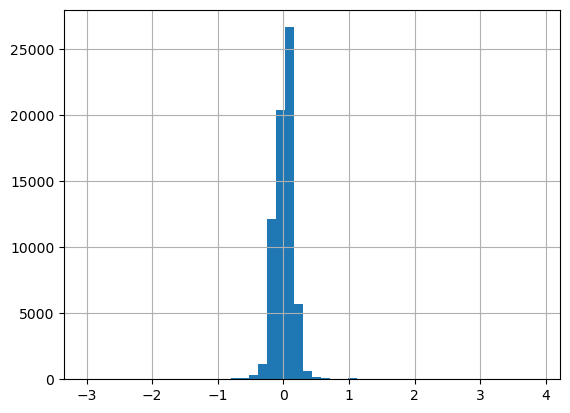

In [10]:
all_runs_to['scoring_ratio'].hist(bins=50)

In [11]:
all_runs_to[(all_runs_to['to']==0)]['scoring_ratio'].describe()

count    60444.000000
mean         0.000512
std          0.174154
min         -3.000000
25%         -0.105263
50%         -0.014493
75%          0.105263
max          3.875000
Name: scoring_ratio, dtype: float64

In [12]:
all_runs_to[(all_runs_to['to']==1)]['scoring_ratio'].describe()

count    7479.000000
mean        0.005625
std         0.114936
min        -2.000000
25%        -0.075906
50%         0.038835
75%         0.082141
max         1.363636
Name: scoring_ratio, dtype: float64

In [13]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)]['scoring_ratio'].describe()

count    6531.000000
mean        0.003172
std         0.115593
min        -2.000000
25%        -0.077586
50%         0.035556
75%         0.081967
max         1.363636
Name: scoring_ratio, dtype: float64

<Axes: xlabel='run_length', ylabel='next_run_length'>

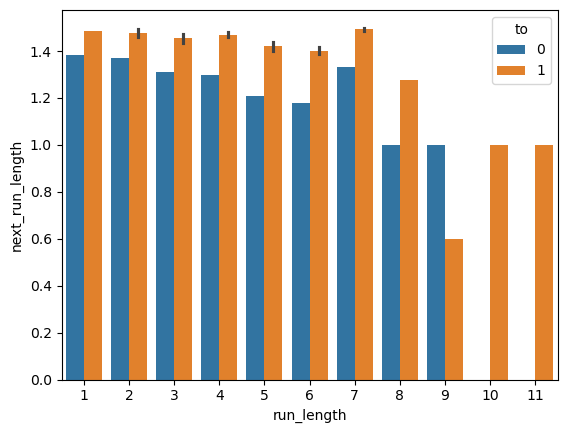

In [14]:
sns.barplot(data = all_runs_to.groupby(['to','changed_run','run_length'],as_index=False)[['next_run_length']].mean(),x='run_length',y='next_run_length',hue='to')

<Axes: xlabel='run_length', ylabel='next_run_length'>

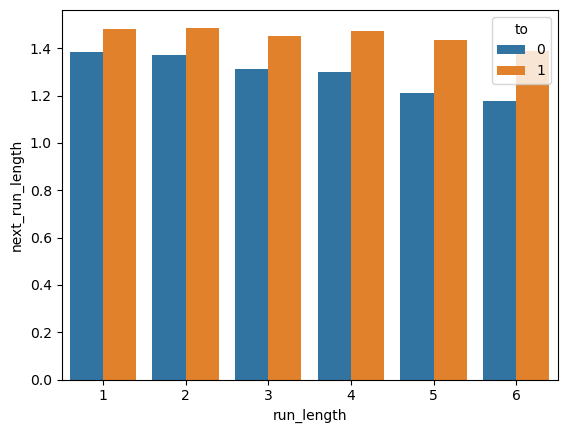

In [15]:
sns.barplot(data=all_runs_to[(all_runs_to['run_length']<7)&(all_runs_to['run_length']<7)].groupby(['to','run_length'])['next_run_length'].mean().reset_index(),
            x='run_length',y='next_run_length',hue='to')

In [16]:
all_runs_to[all_runs_to['to']==1]['changed_run'].value_counts(normalize=True)

changed_run
1    0.668405
0    0.331595
Name: proportion, dtype: float64

In [17]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)]['changed_run'].value_counts(normalize=True)


changed_run
1    0.660695
0    0.339305
Name: proportion, dtype: float64

In [18]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&
            (all_runs_to['avg_opponent_run_length']>0)&
            (all_runs_to['avg_own_run_length']>0)][['avg_opponent_run_length','avg_own_run_length']].describe()

,avg_opponent_run_length,avg_own_run_length
count,6060.000000,6060.000000
mean,1.433578,1.462186
std,0.473360,0.511684
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.333333,1.333333
75%,1.600000,1.666667
max,6.000000,6.000000


In [19]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)]['next_run_length'].describe()

count    4315.000000
mean        1.482966
std         0.869498
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: next_run_length, dtype: float64

In [20]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)]['run_length_continued'].describe()

count    2216.000000
mean        1.510379
std         0.846654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: run_length_continued, dtype: float64

In [21]:
all_runs_to[(all_runs_to['to']!=1)&(all_runs_to['to_non_run']!=1)&(all_runs_to['changed_run']!=1)]['next_run_length'].describe()

count    60444.000000
mean         1.375141
std          0.879526
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         11.000000
Name: next_run_length, dtype: float64

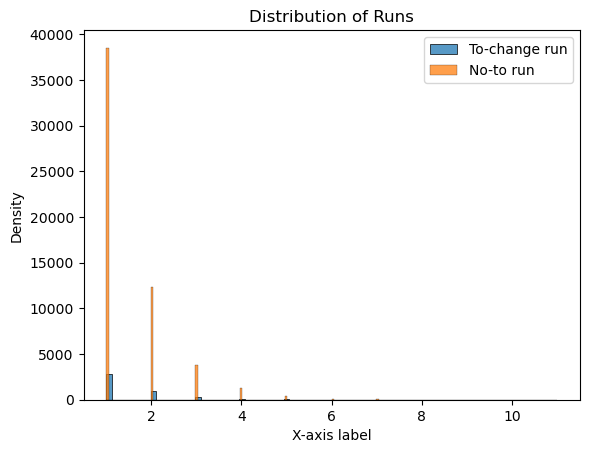

In [22]:
# Plot KDE for Series 1
sns.histplot(data=all_runs_to[(all_runs_to['to'] == 1) & 
                        (all_runs_to['to_non_run'] == 1) & 
                        (all_runs_to['changed_run'] == 1)&(all_runs_to['next_run_length']>0)]['next_run_length'], 
            label='To-change run')

# Plot KDE for Series 2
# sns.histplot(all_runs_to[(all_runs_to['to'] == 1) & 
#                         (all_runs_to['to_non_run'] == 1) & 
#                         (all_runs_to['changed_run'] == 0)]['run_length_continued'], 
#             label='To-no-change run')

# Plot KDE for Series 3
sns.histplot(data=all_runs_to[(all_runs_to['to'] != 1) & 
                        (all_runs_to['to_non_run'] != 1) & 
                        (all_runs_to['changed_run'] != 1)&(all_runs_to['next_run_length']>0)]['next_run_length'], 
            label='No-to run')

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Density')
plt.title('Distribution of Runs')

# Show the legend
plt.legend()

# Display the plot
plt.show()


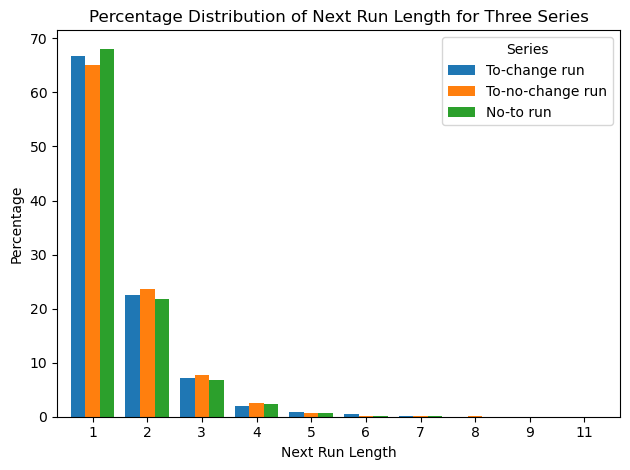

In [23]:
# Define a function to calculate percentages
def calculate_percentages(series):
    counts = series.value_counts().sort_index()
    percentages = (counts / counts.sum()) * 100
    return percentages

# Filter and calculate percentages for each series
series1 = all_runs_to[(all_runs_to['to'] == 1) & 
                      (all_runs_to['to_non_run'] == 1) & 
                      (all_runs_to['changed_run'] == 1)&(all_runs_to['next_run_length']>0)]['next_run_length']
series1_percentages = calculate_percentages(series1)

series2 = all_runs_to[(all_runs_to['to'] == 1) & 
                      (all_runs_to['to_non_run'] == 1) & 
                      (all_runs_to['changed_run'] == 0)]['run_length_continued']
series2_percentages = calculate_percentages(series2)

series3 = all_runs_to[(all_runs_to['to'] != 1) & 
                      (all_runs_to['to_non_run'] != 1) & 
                      (all_runs_to['changed_run'] != 1)&(all_runs_to['next_run_length']>0)]['next_run_length']
series3_percentages = calculate_percentages(series3)

# Combine the series into a DataFrame for easier plotting
percentages_df = pd.DataFrame({
    'To-change run': series1_percentages,
    'To-no-change run': series2_percentages,
    'No-to run': series3_percentages
}).fillna(0)  # Fill NaNs with zeros for values that don't appear in some series

# Plot the bar chart
percentages_df.plot(kind='bar', width=0.8)

# Add labels and title
plt.xlabel('Next Run Length')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Next Run Length for Three Series')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Series')

# Display the plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [24]:
series1.mean()

np.float64(1.4950934579439252)

In [25]:
series2.mean()

np.float64(1.510379061371841)

In [26]:
series3.mean()

np.float64(1.4685595151857807)

In [27]:
percentages_df

,To-change run,To-no-change run,No-to run
1,66.728972,65.162455,68.089542
2,22.570093,23.646209,21.790138
3,7.242991,7.671480,6.811074
4,2.032710,2.481949,2.268591
5,0.887850,0.722022,0.722628
6,0.467290,0.225632,0.215552
7,0.046729,0.045126,0.063605
8,0.000000,0.045126,0.026502
9,0.023364,0.000000,0.010601
11,0.000000,0.000000,0.001767


# Team analysis

In [28]:
team_stats_df = leaguedashteamstats.LeagueDashTeamStats(season='2023-24').get_data_frames()[0]

In [29]:
def plot_with_titles(fig,title_string,subtitle_string,xlabel,ylabel=None):
    figure = fig
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title_string,fontsize=18)
    plt.title(subtitle_string, fontsize=10)
    plt.annotate('Source: nba.com PBP Data', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top',
                fontsize=6, color='gray')
    plt.show()

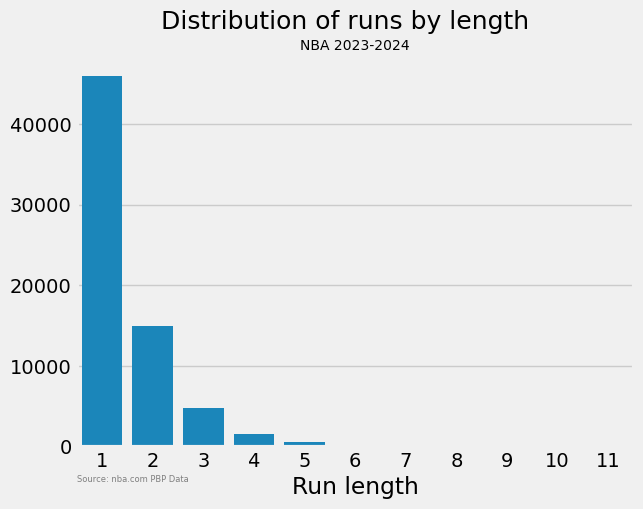

In [32]:
plot_with_titles(sns.barplot(all_runs_to.groupby(['run_length']).size()),'Distribution of runs by length','NBA 2023-2024',xlabel='Run length')

In [33]:
all_runs_to['to'].value_counts()

to
0    60444
1     7479
Name: count, dtype: int64

In [34]:
all_runs_to['to_non_run'].value_counts()

to_non_run
1.0    6531
0.0     948
Name: count, dtype: int64

In [35]:
all_runs_to[all_runs_to['to_non_run']==1]['changed_run'].value_counts()

changed_run
1    4315
0    2216
Name: count, dtype: int64

In [36]:
import plotly.graph_objects as go

# Define the node labels with values
labels = [
    "Total Timeouts (7,479)", 
    "Called by Non-Run Team", 
    "Called by Run Team (948)",
    "Halted Run (4,315)", 
    "Didn't Halt Run (2,216)"
]

# Define the source and target nodes
source = [0, 0, 1, 1]
target = [1, 2, 3, 4]
values = [6531, 948, 4315, 2216]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=source,
        target=target,
        value=values
    )
)])

fig.update_layout(
    title=dict(
        text="Timeouts distribution",
        x=0.5,  # Center the title
        xanchor='center'
    ),
    font=dict(
        family="Arial",  # Use Arial as a substitute for Proxima Nova
        size=14,
        color="black"
    ),
    paper_bgcolor="rgba(245, 246, 249, 1)",  # Light grey background
    plot_bgcolor="rgba(245, 246, 249, 1)",  # Light grey background
    width=600,  # Adjust the width here
    height=400  # You can adjust the height if needed
)

# Show the figure
fig.show()


In [37]:
4315/6531

0.6606951462256928

In [38]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)]['run_length'].describe()

count    4315.000000
mean        2.042642
std         0.956174
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         7.000000
Name: run_length, dtype: float64

In [39]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)]['run_length_continued'].describe()

count    2216.000000
mean        1.510379
std         0.846654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: run_length_continued, dtype: float64

In [40]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)]['next_run_length'].describe()

count    4315.000000
mean        1.482966
std         0.869498
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: next_run_length, dtype: float64

In [41]:
all_runs_to[(all_runs_to['to']==0)]['run_length'].describe()

count    60444.000000
mean         1.350936
std          0.660563
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: run_length, dtype: float64

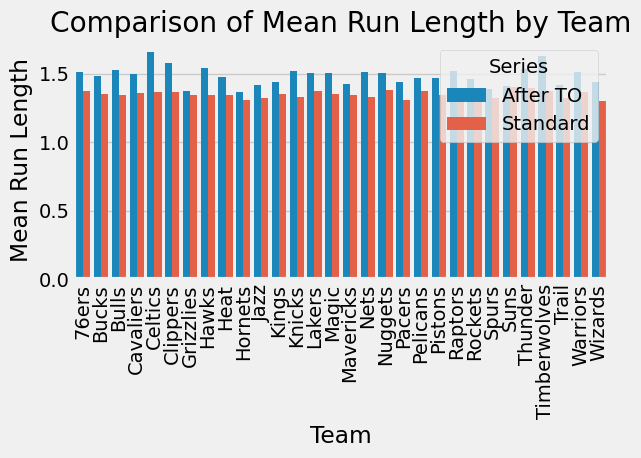

In [42]:
after_to_series = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)].groupby('to_team')['next_run_length'].mean()
std_series = all_runs_to[(all_runs_to['to']==0)].groupby('run_team')['run_length'].mean()
# Convert series to DataFrames and align the indices
df1 = after_to_series.rename('After TO').reset_index()
df2 = std_series.rename('Standard').reset_index()

# Standardize column names to merge them
df1.columns = ['Team', 'After TO']
df2.columns = ['Team', 'Standard']

# Merge the two DataFrames on 'Team'
merged_df = pd.merge(df1, df2, on='Team', how='outer').fillna(0)

# Melt the DataFrame for easier plotting with Seaborn
melted_df = pd.melt(merged_df, id_vars='Team', value_vars=['After TO', 'Standard'], 
                    var_name='Series', value_name='Mean Run Length')

# Plotting
sns.barplot(data=melted_df, x='Team', y='Mean Run Length', hue='Series')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Team')
plt.ylabel('Mean Run Length')
plt.title('Comparison of Mean Run Length by Team')

# Show the plot
plt.tight_layout()
plt.show()

In [43]:
all_runs_to[all_runs_to['to_non_run']==1].groupby(['to_team'])['changed_run'].value_counts(normalize=True)

to_team       changed_run
76ers         1              0.661458
              0              0.338542
Bucks         1              0.717703
              0              0.282297
Bulls         1              0.655660
              0              0.344340
Cavaliers     1              0.612360
              0              0.387640
Celtics       1              0.662921
              0              0.337079
Clippers      1              0.728448
              0              0.271552
Grizzlies     1              0.661538
              0              0.338462
Hawks         1              0.650718
              0              0.349282
Heat          1              0.630435
              0              0.369565
Hornets       1              0.666667
              0              0.333333
Jazz          1              0.664835
              0              0.335165
Kings         1              0.648241
              0              0.351759
Knicks        1              0.696429
              0         

In [44]:
colors_df = pd.read_csv('data/colors_nba_teams.csv')

In [45]:
colors_df['Color 1'] = colors_df['Color 1'].str.split('#',expand=True)[1]
colors_df['Color 1'] = [f"#{x}" for x in colors_df['Color 1']]

In [46]:
colors_df['Team'] = [x[-1] for x in colors_df['NBA Team Name'].str.split(' ')]

In [47]:
team_stats_df['Team'] = [x[-1] for x in team_stats_df['TEAM_NAME'].str.split(' ')]

In [48]:
team_stats_df = team_stats_df.merge(colors_df[['Team','Color 1']],on='Team',how='left')

In [49]:
melted_df = melted_df.merge(team_stats_df[['Team','W','L','W_PCT','Color 1']],on='Team',how='left')

In [50]:
melted_df.loc[melted_df['Team']=='Trail',['W','L','W_PCT','Color 1']] = team_stats_df.loc[team_stats_df['Team'] == 'Blazers',['W','L','W_PCT','Color 1']].values

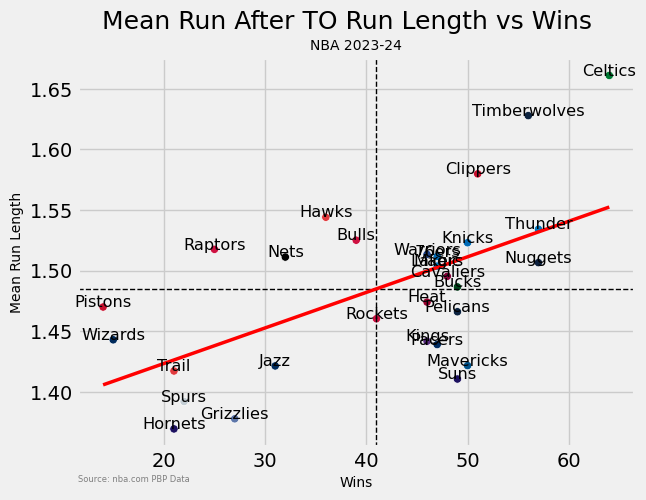

In [310]:
# # Assuming to_changes_run_df and team_colors are already defined
# # Create the scatter plot
# sns.scatterplot(data=to_changes_run_df, x='W', y=to_changes_run_df[0]*100, hue='Team', palette=team_colors, legend=False)

# # Add the mean lines
# plt.axhline(to_changes_run_df[0].mean()*100, color='black', linestyle='--',linewidth=1)
# plt.axvline(to_changes_run_df['W'].mean(), color='black', linestyle='--',linewidth=1)
# # Adding legend manually on top of each dot
# for line in range(0, to_changes_run_df.shape[0]):
#     plt.text(to_changes_run_df.W.iloc[line], to_changes_run_df[0].iloc[line]*100, 
#              to_changes_run_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')
# # Add the regression line
# sns.regplot(data=to_changes_run_df, x='W', y=to_changes_run_df[0]*100, scatter=False, color='red',ci=False,line_kws={'linewidth': 2.5})
# # Set the title and labels with reduced font size
# plt.suptitle("% of runs that halt after timeout vs Wins",fontsize=18)
# plt.xlabel('Wins', fontsize=10)
# plt.title('NBA 2023-24', fontsize=10)
# plt.annotate('Source: nba.com PBP Data', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top',
#             fontsize=6, color='gray')
# plt.ylabel("% of runs that halt after timeout", fontsize=10)

# # Show the plot
# plt.show() 

# Filter the DataFrame for 'After TO' series
after_to_df = melted_df[melted_df['Series'] == 'After TO']

# Create a dictionary mapping each team to its color
team_colors = dict(zip(after_to_df['Team'], after_to_df['Color 1']))

# Create the scatter plot
sns.scatterplot(data=after_to_df, x='W', y='Mean Run Length', hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(after_to_df['Mean Run Length'].mean(), color='black', linestyle='--',linewidth=1)
plt.axvline(after_to_df['W'].mean(), color='black', linestyle='--',linewidth=1)
sns.regplot(data=after_to_df, x='W', y='Mean Run Length', scatter=False, color='red',ci=False,line_kws={'linewidth': 2.5})
# Set the title and labels
plt.suptitle('Mean Run After TO Run Length vs Wins',fontsize=18)
plt.title('NBA 2023-24', fontsize=10)
plt.xlabel('Wins',fontsize=10)
plt.ylabel('Mean Run Length',fontsize=10)
plt.annotate('Source: nba.com PBP Data', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top',
            fontsize=6, color='gray')

# Adding legend manually on top of each dot
for line in range(0, after_to_df.shape[0]):
     plt.text(after_to_df.W.iloc[line], after_to_df['Mean Run Length'].iloc[line], 
     after_to_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()

In [315]:
np.corrcoef(after_to_df['W'],after_to_df['Mean Run Length'])

array([[1.        , 0.58174064],
       [0.58174064, 1.        ]])

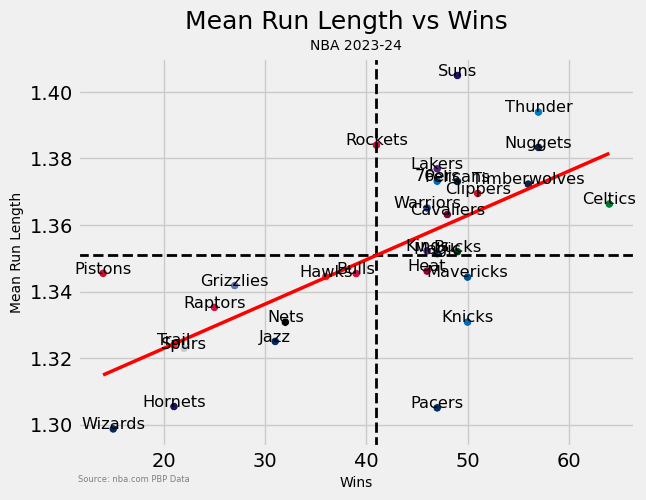

In [314]:
# Filter the DataFrame for 'After TO' series
std_df = melted_df[melted_df['Series'] == 'Standard']

# Create a dictionary mapping each team to its color
team_colors = dict(zip(std_df['Team'], std_df['Color 1']))

# Create the scatter plot
sns.scatterplot(data=std_df, x='W', y='Mean Run Length', hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(std_df['Mean Run Length'].mean(), color='black', linestyle='--',linewidth=2)
plt.axvline(std_df['W'].mean(), color='black', linestyle='--',linewidth=2)

sns.regplot(data=std_df, x='W', y='Mean Run Length', scatter=False, color='red',ci=False,line_kws={'linewidth': 2.5})
# Set the title and labels
plt.suptitle('Mean Run Length vs Wins',fontsize=18)
plt.title('NBA 2023-24', fontsize=10)
plt.xlabel('Wins',fontsize=10)
plt.ylabel('Mean Run Length',fontsize=10)
plt.annotate('Source: nba.com PBP Data', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top',
            fontsize=6, color='gray')
# Adding legend manually on top of each dot
for line in range(0, std_df.shape[0]):
     plt.text(std_df.W.iloc[line], std_df['Mean Run Length'].iloc[line], 
     std_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()

In [316]:
np.corrcoef(std_df['W'],std_df['Mean Run Length'])

array([[1.        , 0.67433107],
       [0.67433107, 1.        ]])

In [345]:
pivoted_runs = melted_df[['Team','Series','Mean Run Length']].pivot(index='Team', columns='Series', values='Mean Run Length').reset_index()
pivoted_runs['Diff'] = pivoted_runs['After TO'] - pivoted_runs['Standard']

In [344]:
pivoted_runs.drop

Index(['Team', 'After TO', 'Standard', 'Diff'], dtype='object', name='Series')

In [362]:
styled_df = pivoted_runs.sort_values('Diff', ascending=False).style.hide(axis='index').format(precision=4).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ffffff'), ('color', '#190f0f'),
                                 ('text-align', 'center')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center'), ('color', '#190f0f')]},  # Removed background-color
    {'selector': 'caption', 'props': [('caption-side', 'bottom'), ('font-size', '1em'), ('color', 'gray'),
                                      ('background-color', '#ffffff'), ('text-align', 'left')]},
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f7'), ('color', '#333333'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]},
     {'selector': 'td.col0', 'props': [('background-color', '#ffffff')]}
]).set_caption("Source: nba.com PBP Data")

# Apply the gradient
styled_df = styled_df.background_gradient(subset=['Diff','After TO','Standard'])


In [374]:
styled_df.export_png('run_comparison.png',table_conversion='matplotlib')

c:\Users\isaac\.conda\envs\timeout_analysis\Lib\site-packages\dataframe_image\converter\matplotlib_table.py:147: FutureWarning:

The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.



<Axes: >

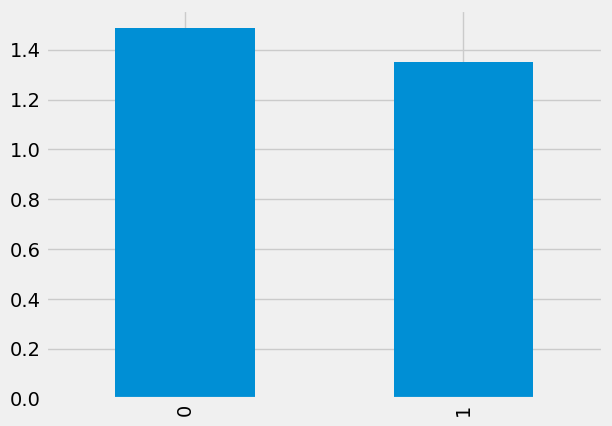

In [53]:
pd.Series([after_to_series.mean(),std_series.mean()]).plot(kind='bar')

In [54]:
merged_df['pct_diff'] = (merged_df['After TO']-merged_df['Standard'])/merged_df['Standard']

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

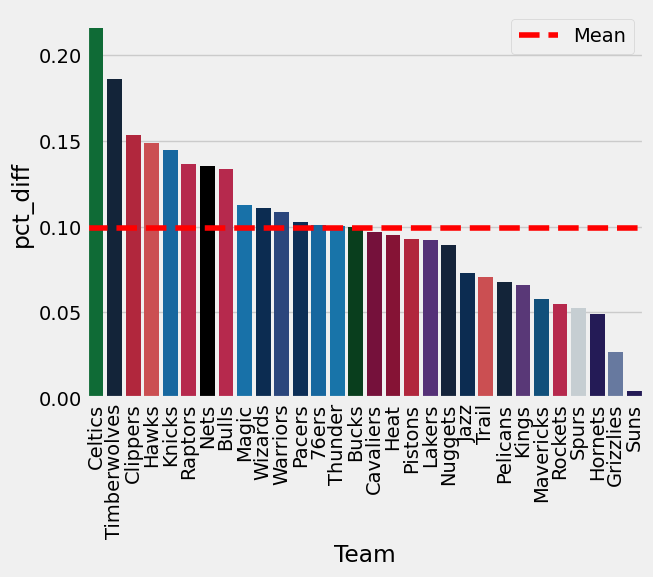

In [55]:
sns.barplot(data=merged_df.sort_values('pct_diff',ascending=False),x='Team',y='pct_diff',color='red',palette=team_colors,hue='Team')
plt.xticks(rotation=90)
plt.axhline(y=merged_df['pct_diff'].mean(),color='red',label='Mean',linestyle='--')
plt.legend()
plt.tight_layout

<Axes: title={'center': 'Average Own Next Run Length for To-change runs'}, xlabel='to_team'>

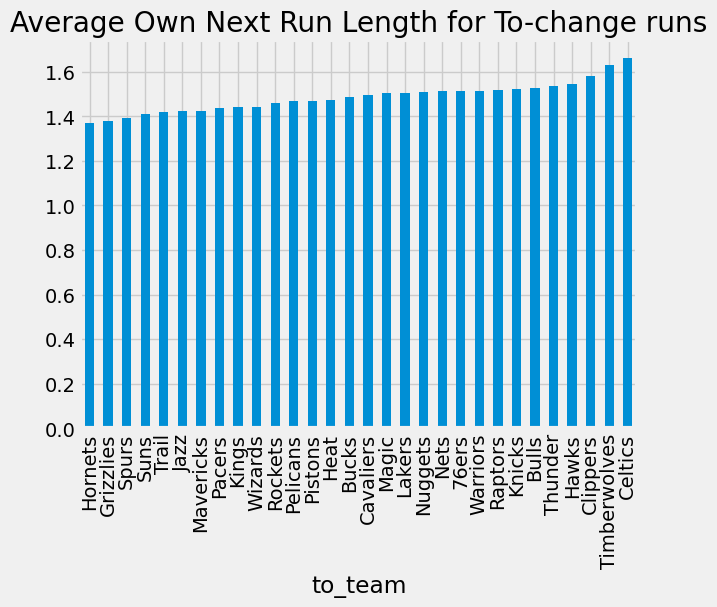

In [57]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)].groupby('to_team')['next_run_length'].mean().sort_values().plot(kind='bar',title='Average Own Next Run Length for To-change runs')

<Axes: title={'center': 'After to, no change run length'}, xlabel='to_team'>

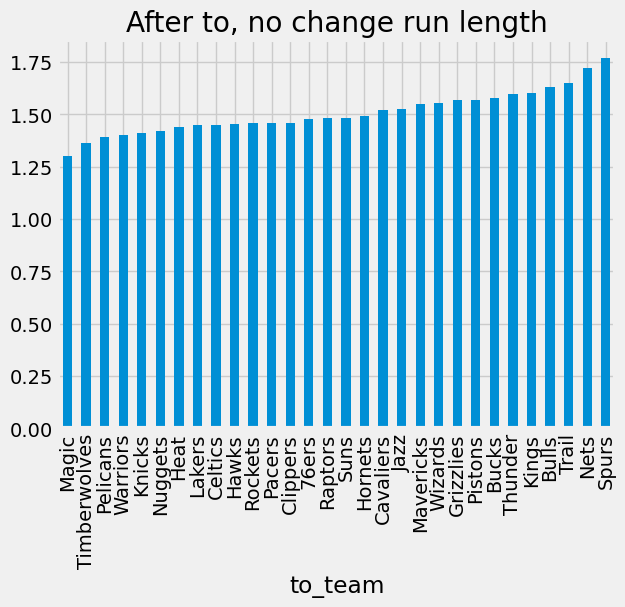

In [58]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)].groupby('to_team')['run_length_continued'].mean().sort_values().plot(kind='bar',title='After to, no change run length')

In [59]:
to_non_change_df = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)].groupby('to_team',as_index = False)['run_length_continued'].mean()

In [60]:
to_non_change_df = to_non_change_df.merge(team_stats_df[['Team','W','L','W_PCT','Color 1']],left_on='to_team',right_on='Team',how='left')
to_non_change_df.loc[to_non_change_df['to_team']=='Trail',['Team','W','L','W_PCT','Color 1']] = team_stats_df.loc[team_stats_df['Team'] == 'Blazers',['Team','W','L','W_PCT','Color 1']].values

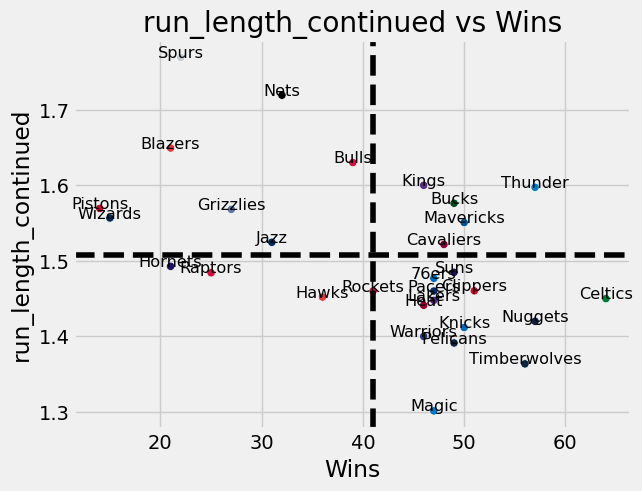

In [61]:
# Create a dictionary mapping each team to its color
team_colors = dict(zip(to_non_change_df['Team'], to_non_change_df['Color 1']))

# Create the scatter plot
sns.scatterplot(data=to_non_change_df, x='W', y='run_length_continued', hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(to_non_change_df['run_length_continued'].mean(), color='black', linestyle='--')
plt.axvline(to_non_change_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('run_length_continued vs Wins')
plt.xlabel('Wins')
plt.ylabel('run_length_continued')

# Adding legend manually on top of each dot
for line in range(0, to_non_change_df.shape[0]):
     plt.text(to_non_change_df.W.iloc[line], to_non_change_df['run_length_continued'].iloc[line], 
     to_non_change_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()        


In [62]:
to_changes_run_df = pd.concat([all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==1)].groupby('to_team').size(),all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)&(all_runs_to['changed_run']==0)].groupby('to_team').size()],
          axis=1)

In [63]:
to_changes_run_df['total'] = to_changes_run_df[0] + to_changes_run_df[1]
to_changes_run_df[0] = to_changes_run_df[0]/to_changes_run_df['total']
to_changes_run_df[1] = to_changes_run_df[1]/to_changes_run_df['total']
to_changes_run_df.drop('total',axis=1,inplace=True)
to_changes_run_df.reset_index(inplace=True)

In [64]:
to_changes_run_df = to_changes_run_df.merge(team_stats_df[['Team','W','L','W_PCT','Color 1']],left_on='to_team',right_on='Team',how='left')
to_changes_run_df.loc[to_changes_run_df['to_team']=='Trail',['Team','W','L','W_PCT','Color 1']] = team_stats_df.loc[team_stats_df['Team'] == 'Blazers',['Team','W','L','W_PCT','Color 1']].values

C:\Users\isaac\AppData\Local\Temp\ipykernel_6236\2951188823.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




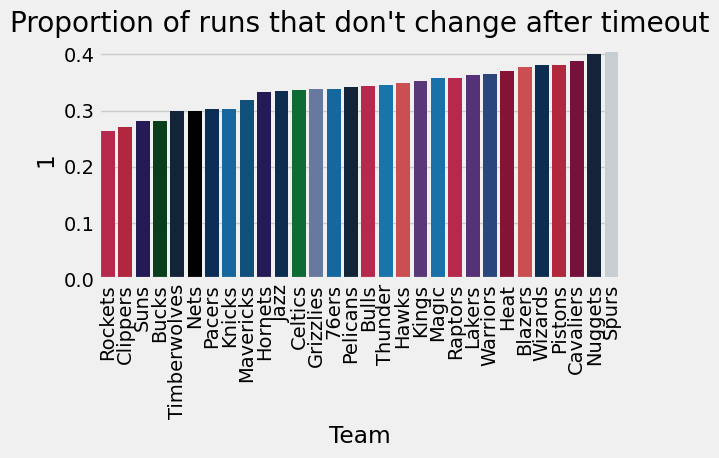

In [66]:
sns.barplot(data = to_changes_run_df.sort_values(1),x='Team',y=1,palette=team_colors)
plt.title("Proportion of runs that don't change after timeout")
plt.xticks(rotation=90)
# Adjust layout to prevent overlap
plt.tight_layout()

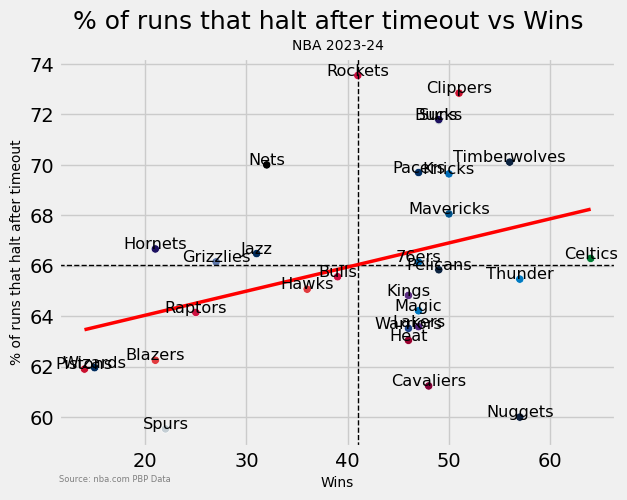

In [67]:
# Assuming to_changes_run_df and team_colors are already defined
# Create the scatter plot
sns.scatterplot(data=to_changes_run_df, x='W', y=to_changes_run_df[0]*100, hue='Team', palette=team_colors, legend=False)

# Add the mean lines
plt.axhline(to_changes_run_df[0].mean()*100, color='black', linestyle='--',linewidth=1)
plt.axvline(to_changes_run_df['W'].mean(), color='black', linestyle='--',linewidth=1)
# Adding legend manually on top of each dot
for line in range(0, to_changes_run_df.shape[0]):
    plt.text(to_changes_run_df.W.iloc[line], to_changes_run_df[0].iloc[line]*100, 
             to_changes_run_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')
# Add the regression line
sns.regplot(data=to_changes_run_df, x='W', y=to_changes_run_df[0]*100, scatter=False, color='red',ci=False,line_kws={'linewidth': 2.5})
# Set the title and labels with reduced font size
plt.suptitle("% of runs that halt after timeout vs Wins",fontsize=18)
plt.xlabel('Wins', fontsize=10)
plt.title('NBA 2023-24', fontsize=10)
plt.annotate('Source: nba.com PBP Data', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top',
            fontsize=6, color='gray')
plt.ylabel("% of runs that halt after timeout", fontsize=10)

# Show the plot
plt.show() 

In [381]:
pivoted_runs.merge(melted_df)[['Diff','W']].corr()

,Diff,W
Diff,1.000000,0.348492
W,0.348492,1.000000


In [80]:
to_non_run_df = all_runs_to[all_runs_to['to_non_run']==1]

In [402]:
descriptive_columns = ['previous_run_length', 'avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min', 'scoring_ratio',
       'avg_2_scoring_ratio', 'avg_3_scoring_ratio', 'avg_4_scoring_ratio',
       'avg_5_scoring_ratio','net_diff']

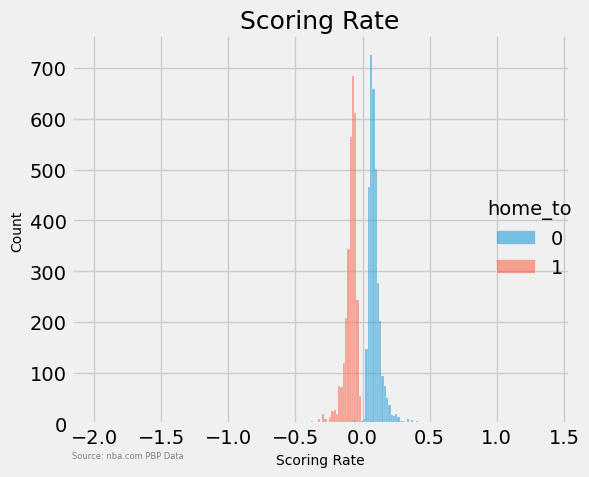

In [411]:
sns.displot(to_non_run_df,x='scoring_ratio',hue='home_to')
#plt.suptitle('NBA 2023-24', fontsize=10)
plt.title('Scoring Rate',fontsize=18)
plt.xlabel('Scoring Rate',fontsize=10)
plt.ylabel('Count',fontsize=10)
plt.annotate('Source: nba.com PBP Data', (0,0), (0, -20), xycoords='axes fraction', textcoords='offset points', va='top',
            fontsize=6, color='gray')
plt.tight_layout()
plt.show()

In [412]:
descriptive_means = to_non_run_df.groupby(['home_to','changed_run'])[descriptive_columns].agg('mean').T

In [413]:
descriptive_means.columns = pd.MultiIndex.from_tuples([
    ('Visitor Timeout', 'Non-halt'), 
    ('Visitor Timeout', 'Halt'),
    ('Home Timeout', 'Non-halt'), 
    ('Home Timeout', 'Halt')
])

In [414]:
descriptive_means.index = [x.replace('_',' ').replace('ratio','rate').title() for x in descriptive_means.index]

In [415]:
descriptive_means.style.format(precision=4).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#ffffff'), ('color', '#190f0f'),
                                       ('text-align', 'center')]},
    {'selector': 'tbody td', 'props': [('text-align', 'center'),('color', '#190f0f'),
                                       ('background-color', '#ffffff')]},
    {'selector': 'caption', 'props': [('caption-side', 'bottom'), ('font-size', '1em'), ('color', 'gray'),
                                      ('background-color', '#ffffff'),('text-align', 'left')]},
    {'selector': 'thead th', 'props': [('background-color', '#f7f7f7'), ('color', '#333333'), ('font-weight', 'bold'), ('border-bottom', '2px solid black')]}

]).set_caption("Source: nba.com PBP Data")

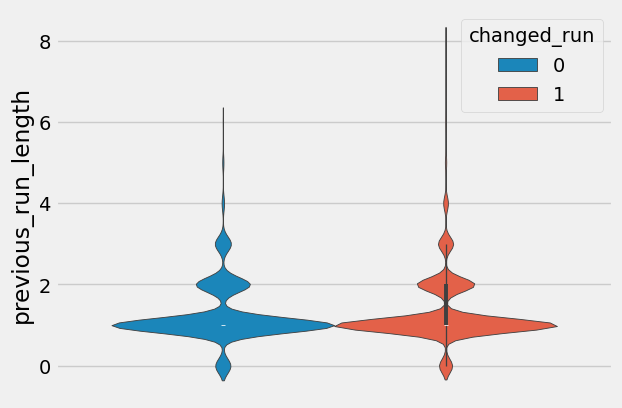

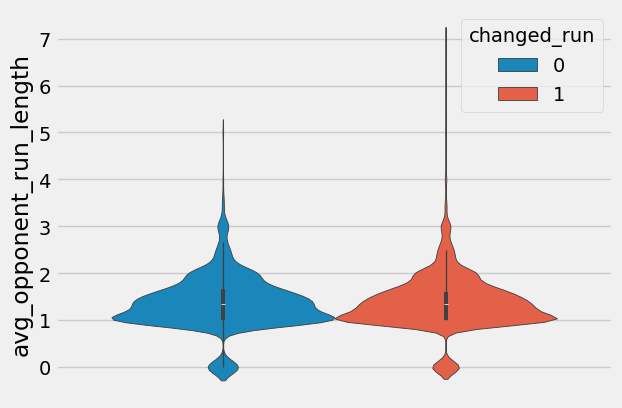

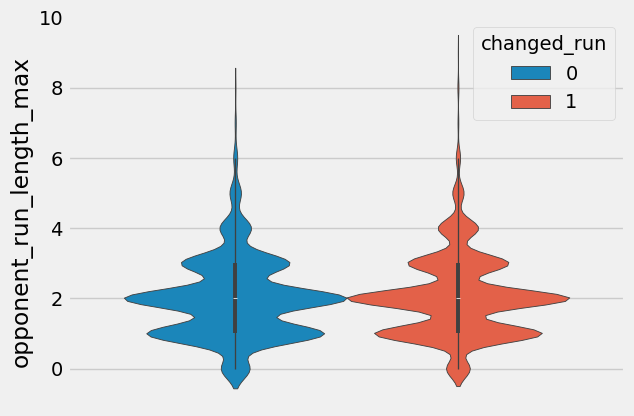

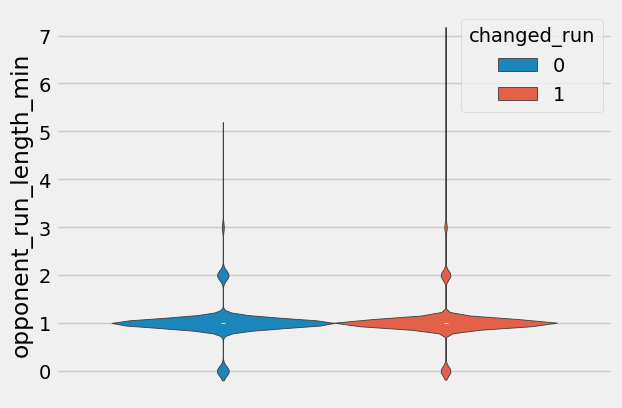

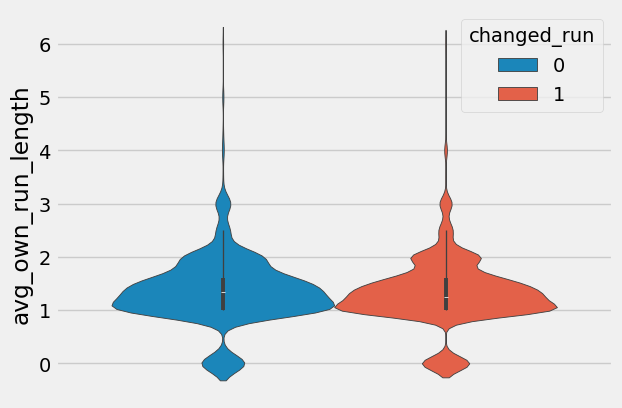

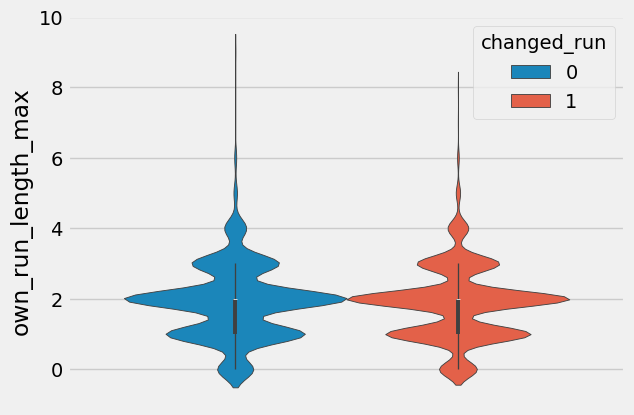

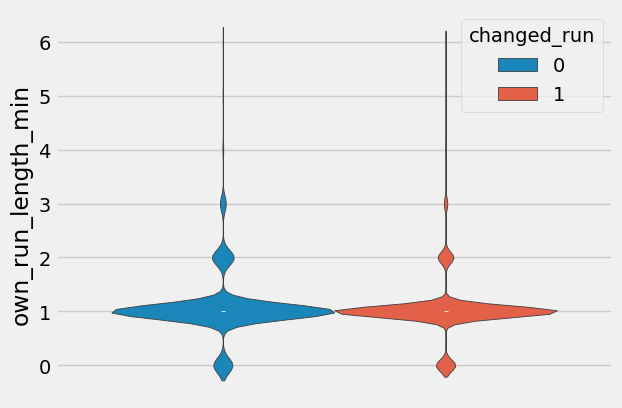

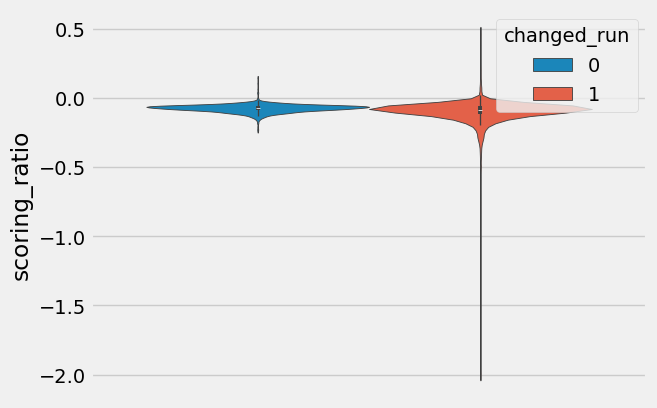

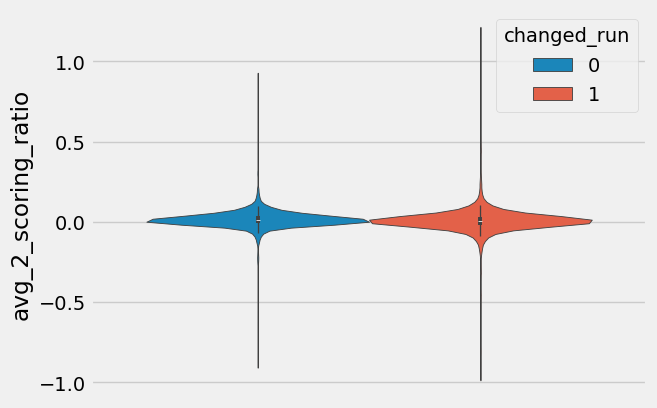

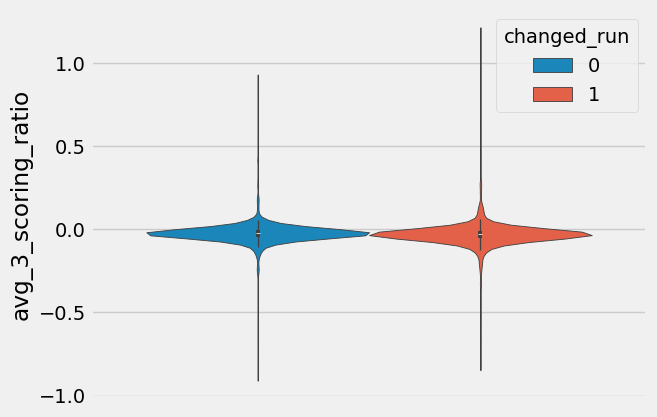

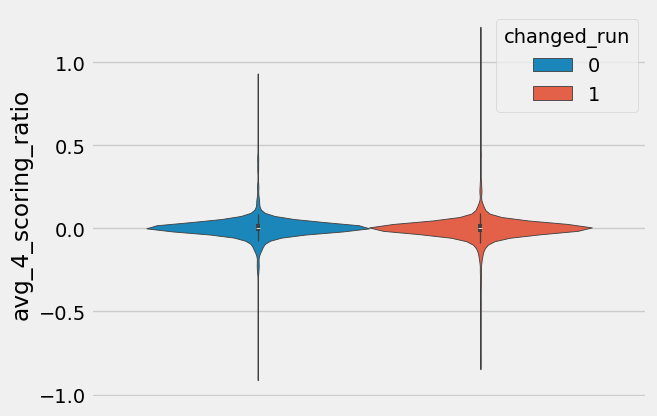

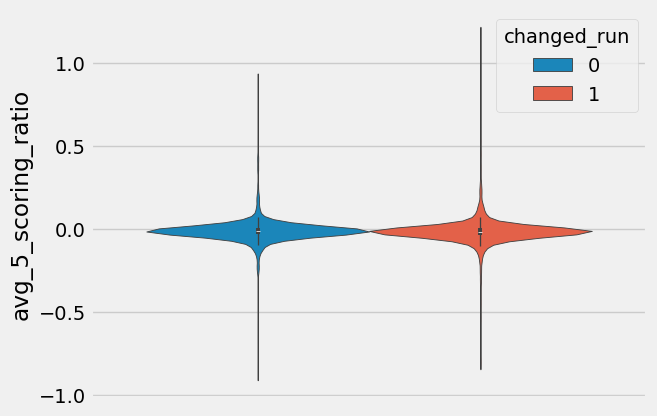

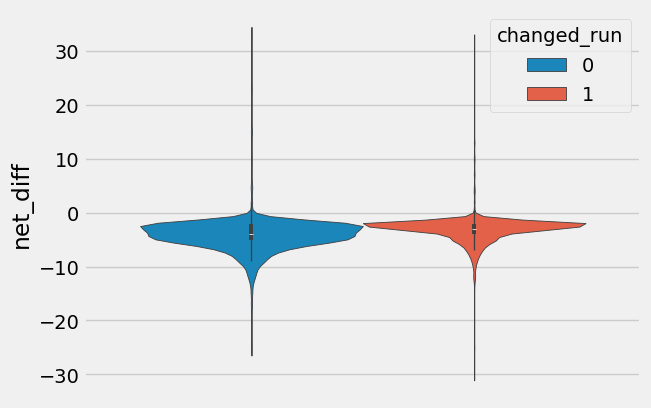

In [431]:
for x in descriptive_columns:
    sns.violinplot(to_non_run_df[to_non_run_df['home_to']==1],y=x,hue='changed_run')
    plt.show()

In [423]:
from scipy.stats import mannwhitneyu

# Assuming df is your DataFrame and y is the target variable
df_1 = to_non_run_df[(to_non_run_df['changed_run'] == 1) & (to_non_run_df['home_to'] == 1)]
df_0 = to_non_run_df[(to_non_run_df['changed_run'] == 0) & (to_non_run_df['home_to'] == 1)]

# Dropping the target variable from features
X_1 = df_1.drop(columns='changed_run')
X_0 = df_0.drop(columns='changed_run')
p_values = []
for column in descriptive_columns:
    u_stat, p_val = mannwhitneyu(X_1[column], X_0[column])
    p_values.append(p_val)
    print(f'Mann-Whitney U test for {column}: U-stat={u_stat}, p-value={p_val}')

Mann-Whitney U test for previous_run_length: U-stat=1111801.0, p-value=0.24438305316970432
Mann-Whitney U test for avg_opponent_run_length: U-stat=1097250.5, p-value=0.7435528750514702
Mann-Whitney U test for opponent_run_length_max: U-stat=1117027.5, p-value=0.22861158983999796
Mann-Whitney U test for opponent_run_length_min: U-stat=1094797.5, p-value=0.670813357807895
Mann-Whitney U test for avg_own_run_length: U-stat=1044445.0, p-value=0.05626624269314916
Mann-Whitney U test for own_run_length_max: U-stat=1069987.0, p-value=0.3872660557102757
Mann-Whitney U test for own_run_length_min: U-stat=1055689.0, p-value=0.02624899871320195
Mann-Whitney U test for scoring_ratio: U-stat=835259.0, p-value=2.2333423139377748e-26
Mann-Whitney U test for avg_2_scoring_ratio: U-stat=972299.0, p-value=9.605849799700605e-07
Mann-Whitney U test for avg_3_scoring_ratio: U-stat=977709.0, p-value=2.961821346574512e-06
Mann-Whitney U test for avg_4_scoring_ratio: U-stat=1041133.5, p-value=0.04309222929977

In [424]:
from statsmodels.stats.multitest import multipletests
  # List of p-values from the tests
reject,p_vals_corrected,_,_ = multipletests(p_values, method='bonferroni',alpha=0.01)

In [426]:
print(dict(zip(descriptive_columns,reject)))

{'previous_run_length': np.False_, 'avg_opponent_run_length': np.False_, 'opponent_run_length_max': np.False_, 'opponent_run_length_min': np.False_, 'avg_own_run_length': np.False_, 'own_run_length_max': np.False_, 'own_run_length_min': np.False_, 'scoring_ratio': np.True_, 'avg_2_scoring_ratio': np.True_, 'avg_3_scoring_ratio': np.True_, 'avg_4_scoring_ratio': np.False_, 'avg_5_scoring_ratio': np.False_, 'net_diff': np.True_}


In [427]:
from scipy.stats import mannwhitneyu

# Assuming df is your DataFrame and y is the target variable
df_1 = to_non_run_df[(to_non_run_df['changed_run'] == 1) & (to_non_run_df['home_to'] == 0)]
df_0 = to_non_run_df[(to_non_run_df['changed_run'] == 0) & (to_non_run_df['home_to'] == 0)]

# Dropping the target variable from features
X_1 = df_1.drop(columns='changed_run')
X_0 = df_0.drop(columns='changed_run')
p_values = []
for column in descriptive_columns:
    u_stat, p_val = mannwhitneyu(X_1[column], X_0[column])
    p_values.append(p_val)
    print(f'Mann-Whitney U test for {column}: U-stat={u_stat}, p-value={p_val}')

Mann-Whitney U test for previous_run_length: U-stat=1306499.0, p-value=0.8885049998942749
Mann-Whitney U test for avg_opponent_run_length: U-stat=1300419.0, p-value=0.9094951635327672
Mann-Whitney U test for opponent_run_length_max: U-stat=1306051.0, p-value=0.9198473177049928
Mann-Whitney U test for opponent_run_length_min: U-stat=1316590.5, p-value=0.3327930387250372
Mann-Whitney U test for avg_own_run_length: U-stat=1316709.0, p-value=0.6211686037702228
Mann-Whitney U test for own_run_length_max: U-stat=1316159.0, p-value=0.6205511452387505
Mann-Whitney U test for own_run_length_min: U-stat=1308574.5, p-value=0.7660956043839309
Mann-Whitney U test for scoring_ratio: U-stat=1585966.0, p-value=1.8863087615453667e-25
Mann-Whitney U test for avg_2_scoring_ratio: U-stat=1438911.0, p-value=5.765200842607353e-07
Mann-Whitney U test for avg_3_scoring_ratio: U-stat=1416065.0, p-value=3.241279954157202e-05
Mann-Whitney U test for avg_4_scoring_ratio: U-stat=1417206.5, p-value=2.69351619979806

In [428]:
from statsmodels.stats.multitest import multipletests
  # List of p-values from the tests
reject,p_vals_corrected,_,_ = multipletests(p_values, method='bonferroni',alpha=0.01)

In [430]:
print(dict(zip(descriptive_columns,reject)))

{'previous_run_length': np.False_, 'avg_opponent_run_length': np.False_, 'opponent_run_length_max': np.False_, 'opponent_run_length_min': np.False_, 'avg_own_run_length': np.False_, 'own_run_length_max': np.False_, 'own_run_length_min': np.False_, 'scoring_ratio': np.True_, 'avg_2_scoring_ratio': np.True_, 'avg_3_scoring_ratio': np.True_, 'avg_4_scoring_ratio': np.True_, 'avg_5_scoring_ratio': np.False_, 'net_diff': np.True_}


In [421]:
# Assuming X_1 and X_0 are your two groups for a specific feature
observed_diff, p_value = permutation_test(X_1['net_diff'], X_0['net_diff'])
print(f'Permutation test: Observed difference={observed_diff}, p-value={p_value}')

Permutation test: Observed difference=1.1188555998510776, p-value=0.0


In [422]:
from scipy.stats import ks_2samp

# Assuming X_1 and X_0 are your two groups for a specific feature
ks_stat, p_value = ks_2samp(X_1['net_diff'], X_0['net_diff'])
print(f'Kolmogorov-Smirnov test: KS-stat={ks_stat}, p-value={p_value}')

Kolmogorov-Smirnov test: KS-stat=0.3073619227696182, p-value=1.071800874514764e-122


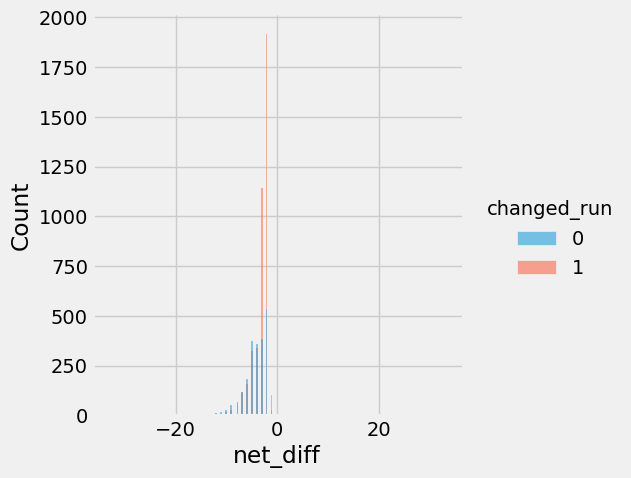

In [153]:
sns.displot(data=to_non_run_df,x='net_diff',hue='changed_run',kind='hist')

C:\Users\isaac\AppData\Local\Temp\ipykernel_5888\2890004829.py:1: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




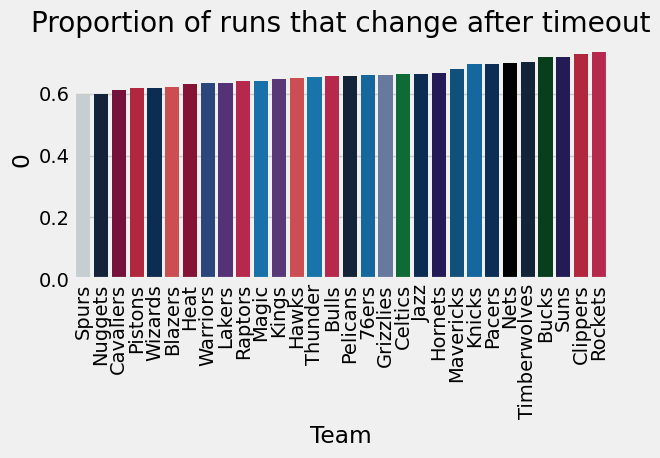

In [244]:
sns.barplot(data = to_changes_run_df.sort_values(0),x='Team',y=0,palette=team_colors)
plt.title("Proportion of runs that change after timeout")
plt.xticks(rotation=90)
# Adjust layout to prevent overlap
plt.tight_layout()

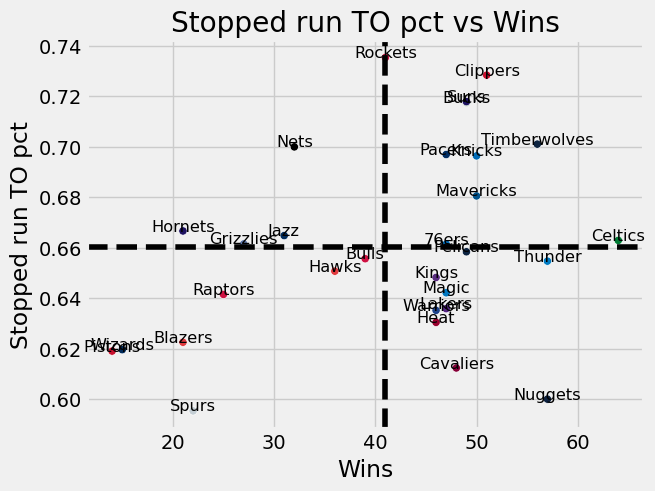

In [245]:
# Create the scatter plot
sns.scatterplot(data=to_changes_run_df, x='W', y=0, hue='Team', palette=team_colors, legend=False)
# Add the mean lines
plt.axhline(to_changes_run_df[0].mean(), color='black', linestyle='--')
plt.axvline(to_changes_run_df['W'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Stopped run TO pct vs Wins')
plt.xlabel('Wins')
plt.ylabel('Stopped run TO pct')

# Adding legend manually on top of each dot
for line in range(0, to_changes_run_df.shape[0]):
     plt.text(to_changes_run_df.W.iloc[line], to_changes_run_df[0].iloc[line], 
     to_changes_run_df['Team'].iloc[line], horizontalalignment='center', size='small', color='black')

# Show the plot
plt.show()   

In [246]:
non_run_to_df_means = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby('to_team')[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index()

In [247]:
team_colors.update({'Trail': '#E03A3E'})

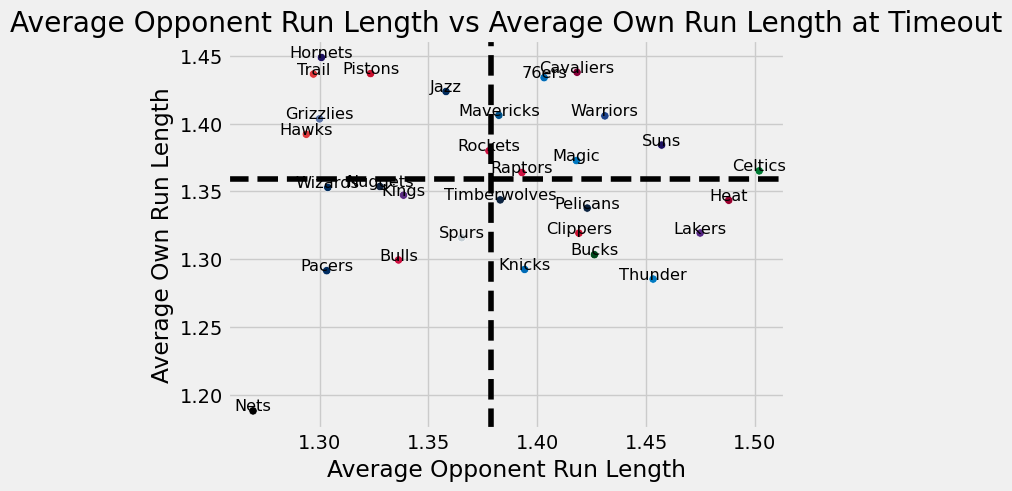

In [257]:
sns.scatterplot(data=non_run_to_df_means, x='avg_opponent_run_length', y='avg_own_run_length',hue='to_team', palette=team_colors, legend=False)
plt.axhline(non_run_to_df_means['avg_own_run_length'].mean(), color='black', linestyle='--')
plt.axvline(non_run_to_df_means['avg_opponent_run_length'].mean(), color='black', linestyle='--')

# Set the title and labels
plt.title('Average Opponent Run Length vs Average Own Run Length at Timeout')
plt.xlabel('Average Opponent Run Length')
plt.ylabel('Average Own Run Length')

# Adding legend manually on top of each dot
for line in range(0, non_run_to_df_means.shape[0]):
     plt.text(non_run_to_df_means['avg_opponent_run_length'].iloc[line], non_run_to_df_means['avg_own_run_length'].iloc[line], 
     non_run_to_df_means['to_team'].iloc[line], horizontalalignment='center', size='small', color='black')

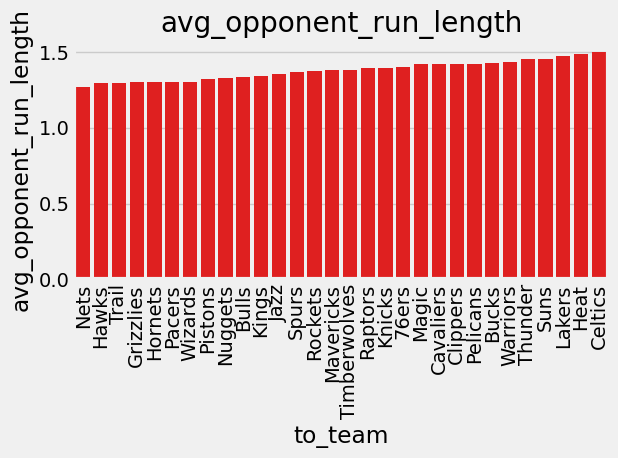

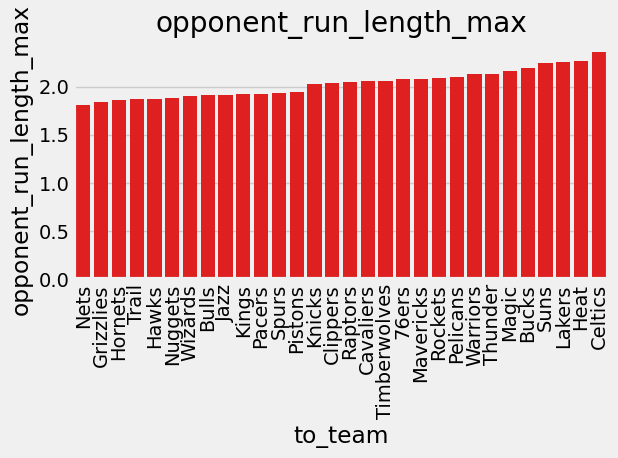

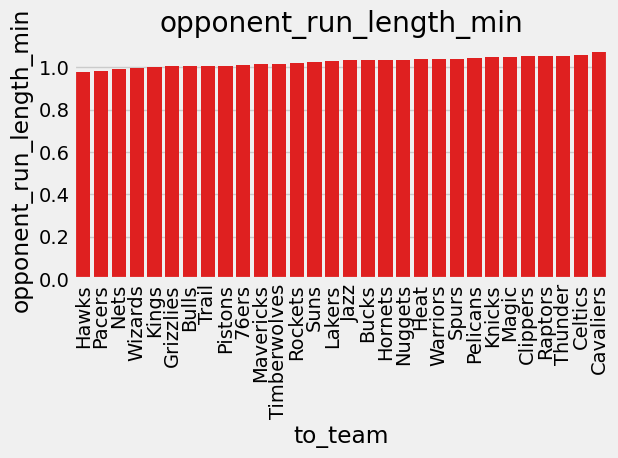

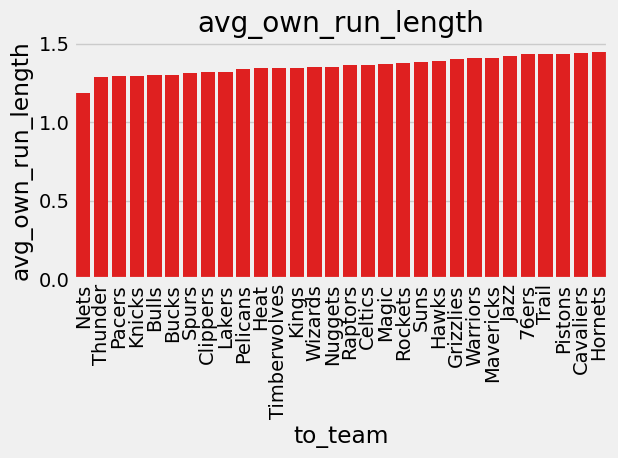

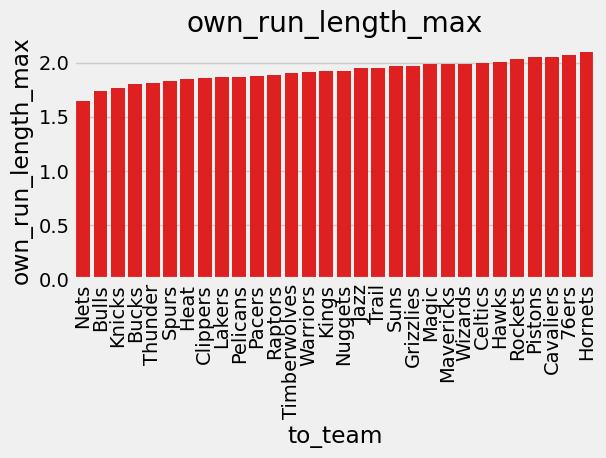

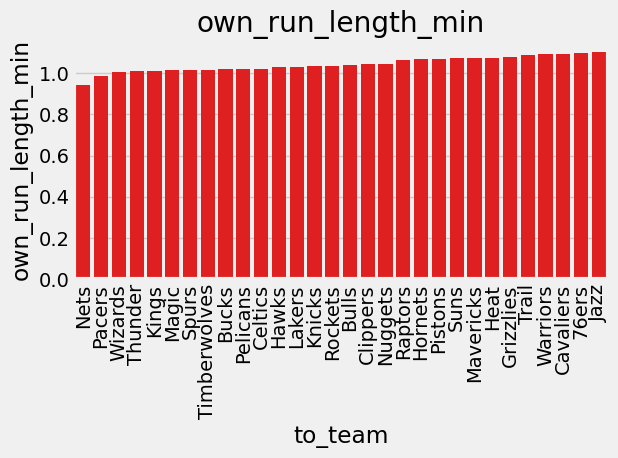

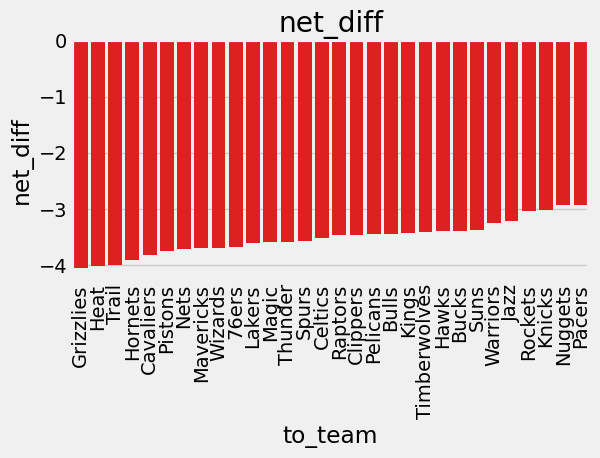

In [249]:
for y in non_run_to_df_means.columns[1:]:
    sns.barplot(data=non_run_to_df_means.sort_values(by=y),x='to_team',y=y,color='red')
    plt.title(f'{y}')
    plt.xticks(rotation=90)
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [250]:
to_changed_run = all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby(['to_team','changed_run'])[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index()

In [251]:
all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby(['changed_run'])[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index()

,changed_run,avg_opponent_run_length,opponent_run_length_max,opponent_run_length_min,avg_own_run_length,own_run_length_max,own_run_length_min,net_diff
0,0,1.372601,2.008574,1.019856,1.367306,1.916968,1.055054,-4.231949
1,1,1.377474,2.034994,1.027115,1.351773,1.914716,1.035921,-3.113094


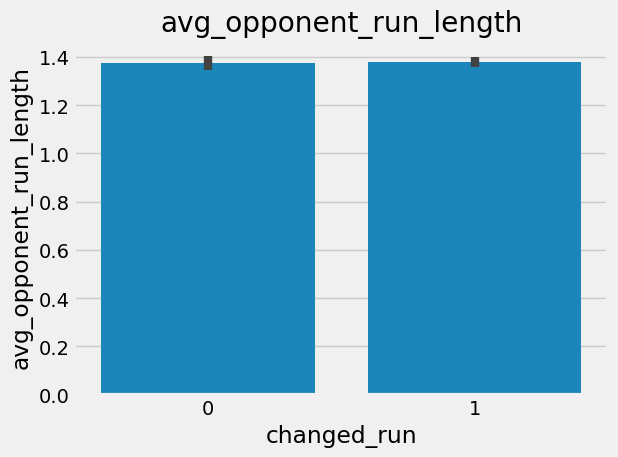

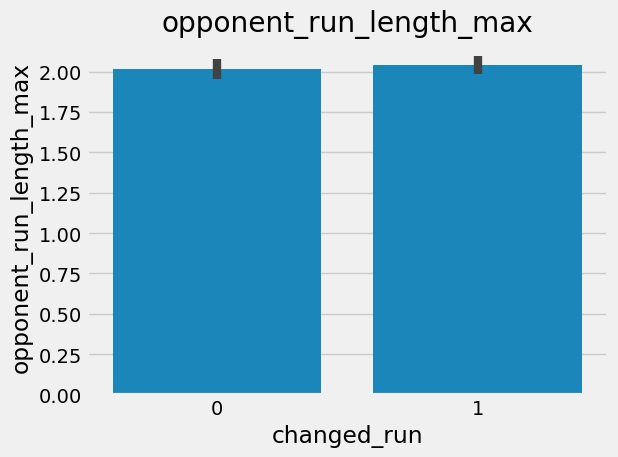

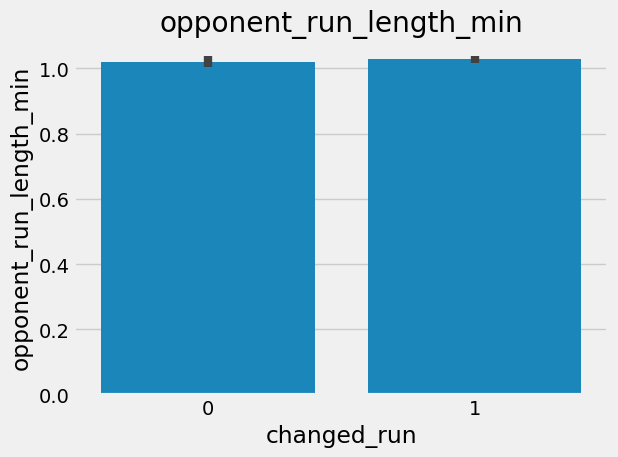

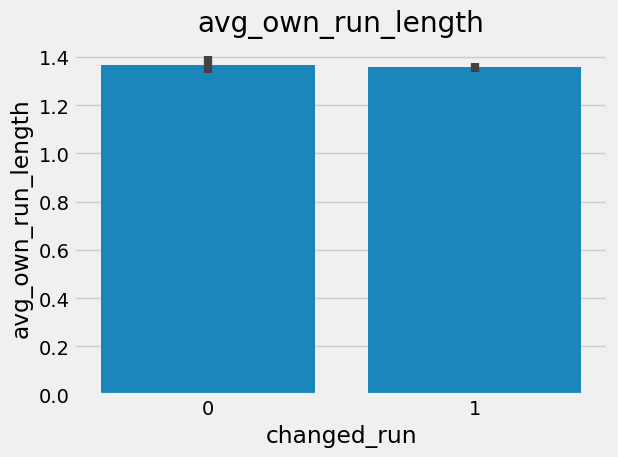

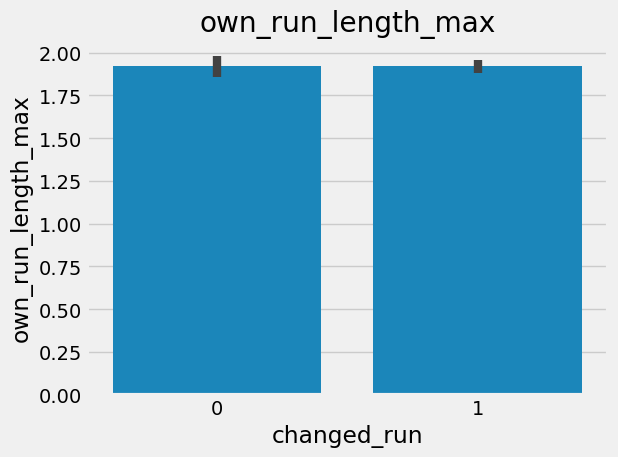

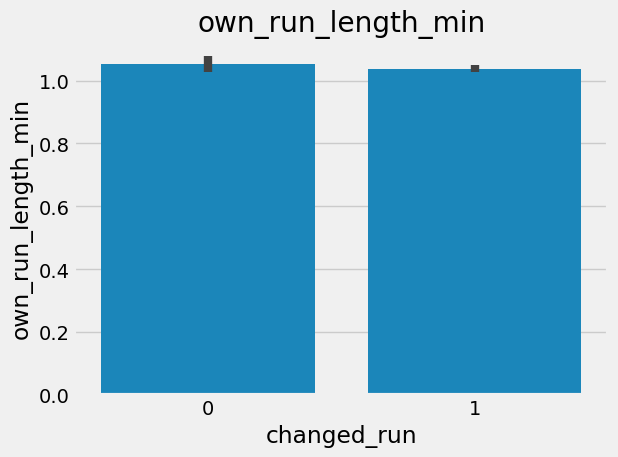

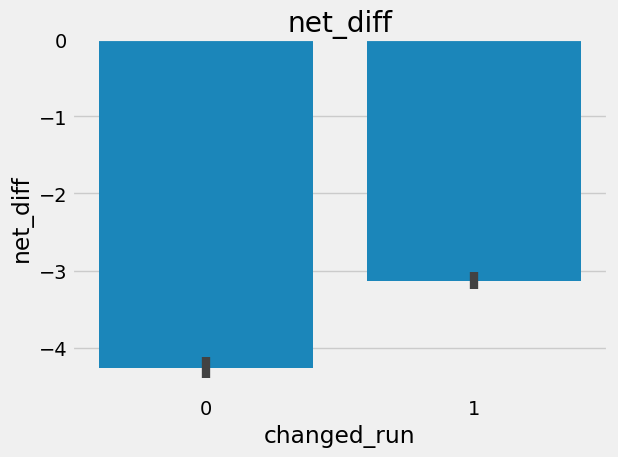

In [252]:
for col in all_runs_to[(all_runs_to['to']==1)&(all_runs_to['to_non_run']==1)].groupby(['changed_run'])[['avg_opponent_run_length',
       'opponent_run_length_max', 'opponent_run_length_min',
       'avg_own_run_length', 'own_run_length_max', 'own_run_length_min',
       'net_diff']].mean().reset_index().columns[1:]:
       sns.barplot(data=to_changed_run,x='changed_run',y=col)
       plt.title(f'{col}')
       plt.tight_layout()
       plt.show()

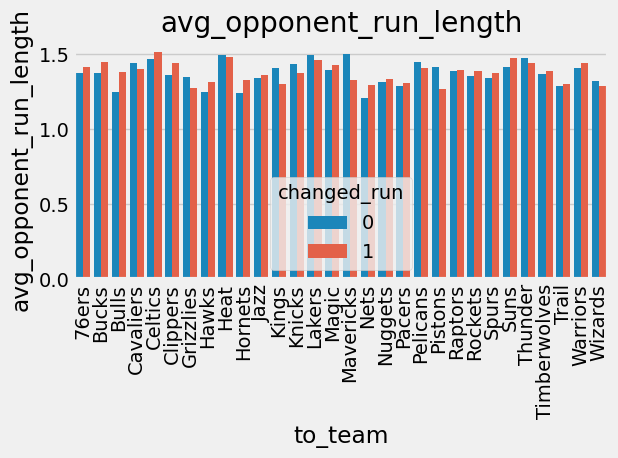

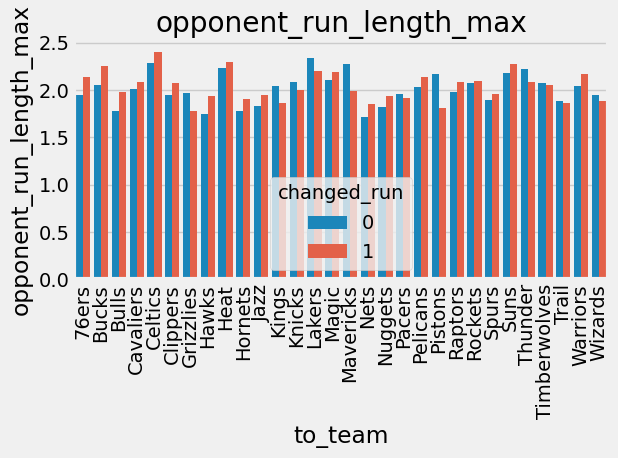

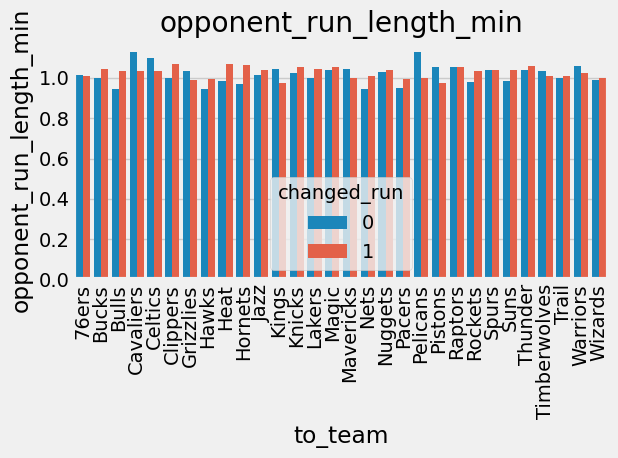

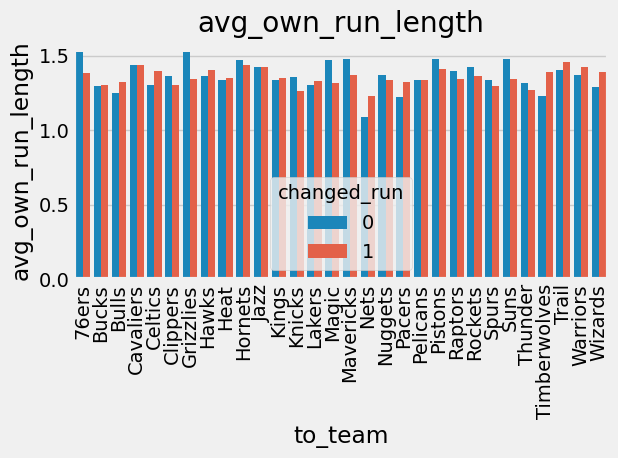

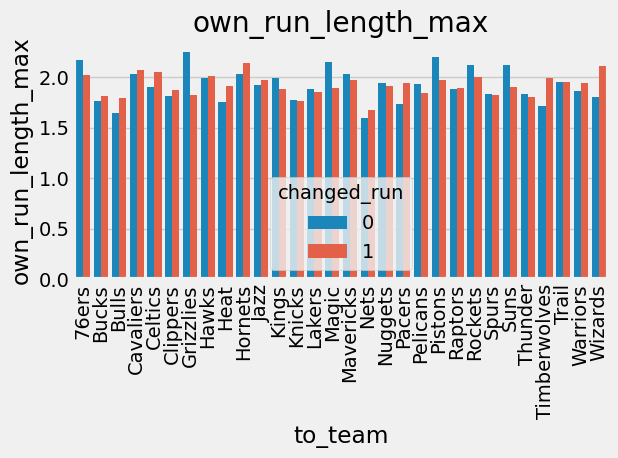

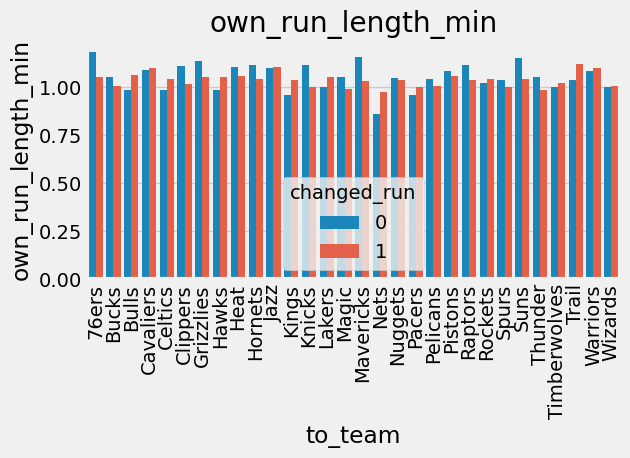

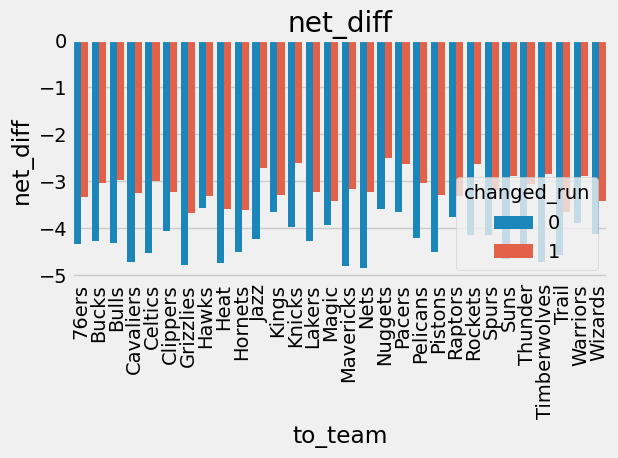

In [253]:
for col in to_changed_run.columns[2:]:
    sns.barplot(data=to_changed_run,x='to_team',y=col,hue='changed_run')
    plt.xticks(rotation=90)
    plt.title(col)
    plt.tight_layout()
    plt.show()